In [5]:
"""Deterministic co-optimization of pumped hydro and wind generation.

This module implements the deterministic linear program described by
Vespucci et al. (2012), "A stochastic model for the daily coordination of pumped
storage hydro plants and wind power plants". The implementation follows the
notation used in Section 2 of the paper and mirrors the deterministic case
presented before the stochastic extension.

The model is solved with SciPy's ``linprog`` (HiGHS backend). The code is
self-contained so it can be run without a commercial solver.
"""

import numpy as np
import pyomo.environ as pyo
import matplotlib.pyplot as plt

In [40]:
# Create the model
model = pyo.ConcreteModel()

# Map sets to model with doc argument
model.T = pyo.Set(initialize=list(range(1, 25)) , ordered=True, doc="Time periods 1-24")
model.J = pyo.Set(initialize=["v1", "v2"], doc="Reservoir nodes")
model.I = pyo.Set(initialize=["c_1_2", "c_2_1"], doc="Inter-reservoir water flows")
model.K = pyo.Set(initialize=["c_1_building", "c_2_building"], doc="Water demand flows")
model.L = pyo.Set(initialize=["wastewater_house", "rainfall_collection"], doc="Water supply flows")
model.N = pyo.Set(initialize=["n_SP", "n_WP"], doc="Energy supply flows")
model.M = pyo.Set(initialize=["m_demand", "m_treatment", "m_distribution"], doc="Energy demand flows")

# Parameters
model.A = pyo.Param(
    model.I, model.J,
    initialize={
        ("c_1_2", "v1"): -1, ("c_1_2", "v2"): 1,
        ("c_2_1", "v1"): 1, ("c_2_1", "v2"): -1,
    },
    default=0, doc="Inter-reservoir flow incidence matrix (positive into reservoir, negative out)."
)
model.A_k = pyo.Param(
    model.K, model.J,
    initialize={
        ("c_1_building", "v1"): 1, ("c_1_building", "v2"): 0,
        ("c_2_building", "v1"): 0, ("c_2_building", "v2"): 1,

    },
    default=0, doc="Reservoir outflow incidence matrix (positive into reservoir, negative out)."
)
model.A_l = pyo.Param(
    model.L, model.J,
    initialize={
        ("wastewater_house", "v1"): 1, ("wastewater_house", "v2"): 0,
        ("rainfall_collection", "v1"): 0, ("rainfall_collection", "v2"): 1
    },
    default=0, doc="Reservoir inflow incidence matrix (positive into reservoir, negative out)."
)
model.k = pyo.Param(
    model.I, 
    initialize={"c_1_2": 1.0, "c_2_1": -1.7}, 
    default=0, doc="Power generation coefficients for inter-reservoir flows (sign indicates turbine(+)/pump(-))."
)
model.q_max_i = pyo.Param(
    model.I, 
    initialize={"c_1_2": 100, "c_2_1": 50}, 
    default=0, doc="Maximum flow limits for inter-reservoir connections (q_i,t ≤ q_max_i) [m^3/h]."
)
model.q_max_k = pyo.Param(
    model.K, 
    initialize={"c_1_building": 200, "c_2_building": 200}, 
    default=0, doc="Maximum demand-side water flows (q_k,t ≤ q_max_k) [m^3/h]."
)
model.q_max_l = pyo.Param(
    model.L, 
    initialize={"wastewater_house": 1000, "rainfall_collection": 1000}, 
    default=0, doc="Maximum supply-side water inflows (q_l,t ≤ q_max_l) [m^3/h]."
)
model.e_max_m = pyo.Param(
    model.M, 
    initialize={"m_demand": 300, "m_treatment": 200, "m_distribution": 300}, 
    default=0,
    doc="Maximum energy outflows to demand sinks (h_m,t ≤ e_max_m) [MWh]."
)
model.e_max_n = pyo.Param(
    model.N, 
    initialize={"n_SP": 500, "n_WP": 400}, 
    default=0, doc="Maximum energy inflows from supply sources (h_n,t ≤ e_max_n) [MWh]."
)
model.v_init = pyo.Param(
    model.J, 
    initialize={"v1": 50, "v2": 50}, 
    default=0, doc="Initial reservoir volumes v_{j,0} [m^3]."
)
model.v_max = pyo.Param(
    model.J, 
    initialize={"v1": 100, "v2": 50}, 
    default=0, doc="Upper bounds on reservoir volumes (0 ≤ v_{j,t} ≤ v_max_j) [m^3]."
)
model.v_min = pyo.Param(
    model.J, 
    initialize={"v1": 50, "v2": 50}, 
    default=0, doc="Required terminal reservoir volumes v_{j,T} ≥ v_min_j [m^3]."
)
model.demand_house = pyo.Param(
    model.T, 
    initialize={t: 50 if t <= 6 or t >= 19 else 200 for t in model.T}, 
    default=0, doc="Household water demand trajectory over time [m^3/h]."
)
model.wastewater_house = pyo.Param(
    model.T, 
    initialize={t: 10 if t <= 4 else 40 for t in model.T}, 
    default=0, doc="Household wastewater production over time [m^3/h]."
)
model.rainfall_collection = pyo.Param(
    model.T, 
    initialize={t: 20 if t <= 4 or t >= 7 else 80 for t in model.T}, 
    default=0, doc="Rainwater harvesting inflow over time [m^3/h]."
)
model.e_house = pyo.Param(
    model.T, 
    initialize={t: 30 if t <= 6 or t >= 19 else 60 for t in model.T}, 
    default=0, doc="Household electric demand trajectory over time [MWh]."
)
model.solar_house = pyo.Param(
    model.T, 
    initialize={t: 0 if t <= 6 or t >= 19 else 80 for t in model.T}, 
    default=0, doc="Solar PV generation available over time [MWh]."
)
model.turbine = pyo.Param(
    model.T, 
    initialize={t: 50 for t in model.T}, 
    default=0, doc="Turbine-related energy contribution term (e.g., max available/coeff) over time."
)
model.e_treatment = pyo.Param(
    model.T, 
    initialize={t: 25 for t in model.T}, 
    default=0, doc="Electricity required for water/wastewater treatment over time [MWh]."
)
model.e_distribution = pyo.Param(
    model.T, 
    initialize={t: 15 for t in model.T}, 
    default=0, doc="Electricity required for water distribution over time [MWh]."
)
model.lambda_t = pyo.Param(
    model.T, 
    initialize={t: 1 for t in model.T}, 
    default=0, doc="Unit selling price for water/energy at time t."
)
model.mu_t = pyo.Param(
    model.T, 
    initialize={t: 1 for t in model.T}, 
    default=0, doc="Unit buying price for water/energy at time t."
)

# Variables
model.q_i = pyo.Var(model.I, model.T, domain=pyo.NonNegativeReals)  # Inter-reservoir flows
model.q_k = pyo.Var(model.K, model.T, domain=pyo.NonNegativeReals)  # Demand flows
model.q_l = pyo.Var(model.L, model.T, domain=pyo.NonNegativeReals)  # Supply flows
model.e_m = pyo.Var(model.M, model.T, domain=pyo.NonNegativeReals)  # Supply currents
model.e_n = pyo.Var(model.N, model.T, domain=pyo.NonNegativeReals)  # Demand currents
model.v = pyo.Var(model.J, model.T, domain=pyo.NonNegativeReals)    # Reservoir volumes
model.W_sell = pyo.Var(model.T, domain=pyo.NonNegativeReals)        # Water sold
model.W_buy = pyo.Var(model.T, domain=pyo.NonNegativeReals)         # Water bought
model.E_sell = pyo.Var(model.T, domain=pyo.NonNegativeReals)        # Energy sold
model.E_buy = pyo.Var(model.T, domain=pyo.NonNegativeReals)         # Energy bought

# Constraints

# Flow limits (Constraint 2)
def flow_limit_i_rule(model, i, t):
    return model.q_i[i, t] <= model.q_max_i[i]
model.flow_limit_i = pyo.Constraint(model.I, model.T, rule=flow_limit_i_rule)

def flow_limit_s_rule(model, k, t):
    return model.q_k[k, t] <= model.q_max_k[k]
model.flow_limit_k = pyo.Constraint(model.K, model.T, rule=flow_limit_s_rule)

def flow_limit_d_rule(model, l, t):
    return model.q_l[l, t] <= model.q_max_l[l]
model.flow_limit_l = pyo.Constraint(model.L, model.T, rule=flow_limit_d_rule)

def current_limit_k_rule(model, m, t):
    return model.e_m[m, t] <= model.e_max_m[m]
model.current_limit_m = pyo.Constraint(model.M, model.T, rule=current_limit_k_rule)

def current_limit_p_rule(model, n, t):
    return model.e_n[n, t] <= model.e_max_n[n]
model.current_limit_n = pyo.Constraint(model.N, model.T, rule=current_limit_p_rule)

# Storage limits (Constraint 3)
def storage_limit_rule(model, j, t):
    return model.v[j, t] <= model.v_max[j]
model.storage_limit = pyo.Constraint(model.J, model.T, rule=storage_limit_rule)

# Final storage minimum (Constraint 4)
def final_storage_rule(model, j):
    return model.v[j, max(model.T)] >= model.v_min[j]
model.final_storage = pyo.Constraint(model.J, rule=final_storage_rule)

# Reservoir balance (Constraint 5)
def reservoir_balance_rule(model, j, t):
    # Get previous volume
    if t == min(model.T):
        previous_v = model.v_init[j]
    else:
        t_list = list(model.T)
        t_idx = t_list.index(t)
        previous_t = t_list[t_idx - 1]
        previous_v = model.v[j, previous_t]
    
    supply_flows = sum(model.A_l[l, j] * model.q_l[l, t] for l in model.L)
    demand_flows = sum(model.A_k[k, j] * model.q_k[k, t] for k in model.K)
    inter_flows = sum(model.A[i, j] * model.q_i[i, t] for i in model.I)
    
    return model.v[j, t] == previous_v + supply_flows - demand_flows + inter_flows

model.reservoir_balance = pyo.Constraint(model.J, model.T, rule=reservoir_balance_rule)

# Water demand balance (Constraint 6)
def water_demand_balance_rule(model, t):
    return sum(model.q_k[k, t] for k in model.K) == model.demand_house[t] + model.W_sell[t]
model.water_demand_balance = pyo.Constraint(model.T, rule=water_demand_balance_rule)

# Water supply balance (Constraint 7)
def water_supply_balance_rule(model,  t):
    return (sum(model.q_l[l, t] for l in model.L) == 
            model.wastewater_house[t] + model.rainfall_collection[t] + model.W_buy[t])
model.water_supply_balance = pyo.Constraint(model.T, rule=water_supply_balance_rule)

# Electrical balance (Constraint 8)
def electrical_balance_rule(model, t):
    return sum(model.e_n[n, t] for n in model.N) + sum(model.k[i] * model.q_i[i, t] for i in model.I) == sum(model.e_m[m, t] for m in model.M)
model.electrical_balance = pyo.Constraint(model.T, rule=electrical_balance_rule)

# Electrical supply balance (Constraint 9)
def electrical_supply_balance_rule(model, t):
    return (sum(model.e_n[n, t] for n in model.N) == 
            model.solar_house[t] + model.turbine[t] + model.E_buy[t])
model.electrical_supply_balance = pyo.Constraint(model.T, rule=electrical_supply_balance_rule)

# Electrical demand balance (Constraint 10)
def electrical_demand_balance_rule(model, t):
    return (sum(model.e_m[m, t] for m in model.M) == 
            model.e_house[t] + model.e_treatment[t] + model.e_distribution[t] + model.E_sell[t])
model.electrical_demand_balance = pyo.Constraint(model.T, rule=electrical_demand_balance_rule)

# Objective function (Equation 1)
def objective_rule(model):
    return sum(model.lambda_t[t] * (model.W_sell[t] + model.E_sell[t]) - 
               model.mu_t[t] * (model.W_buy[t] + model.E_buy[t]) for t in model.T)
model.objective = pyo.Objective(rule=objective_rule, sense=pyo.maximize)

# Solve the model
solver = pyo.SolverFactory('gurobi')  # You can change this to 'gurobi' if you have Gurobi license
results = solver.solve(model, tee=True)

Read LP format model from file /var/folders/3w/hd5h2k7x1vj43929dpnp39p40000gn/T/tmppudv28e2.pyomo.lp
Reading time = 0.00 seconds
x1: 482 rows, 408 columns, 1080 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 25.0.0 25A354)

CPU model: Apple M1 Max
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 482 rows, 408 columns and 1080 nonzeros
Model fingerprint: 0x84ab6c26
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+03]
Presolve removed 386 rows and 169 columns
Presolve time: 0.00s
Presolved: 96 rows, 239 columns, 429 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.1266240e+03   1.321656e+03   0.000000e+00      0s
      41    9.6000000e+02   0.000000e+00   0.000000e+00      0s

Solved in 41 iterations and 0.00 seconds (0.00 work units)
Optimal objective  9.60000

In [41]:
def plot_results(results, model):
    # Check solver status
    if results.solver.termination_condition == pyo.TerminationCondition.optimal:
        print("Optimal solution found!")
        print(f"Objective value: {pyo.value(model.objective):.2f}")
    
    # Print solution summary
        print("\n=== SOLUTION SUMMARY ===")
    
        print("\nReservoir Volumes (final):")
        for j in model.J:
            final_t = max(model.T)
            print(f"v[{j}, {final_t}] = {pyo.value(model.v[j, final_t]):.2f}")
    
        print("\nTotal Water Transactions:")
        total_w_buy = sum(pyo.value(model.W_buy[t]) for t in model.T)
        total_w_sell = sum(pyo.value(model.W_sell[t]) for t in model.T)
        print(f"Total Water Bought: {total_w_buy:.2f}")
        print(f"Total Water Sold: {total_w_sell:.2f}")
    
        print("\nTotal Energy Transactions:")
        total_e_buy = sum(pyo.value(model.E_buy[t]) for t in model.T)
        total_e_sell = sum(pyo.value(model.E_sell[t]) for t in model.T)
        print(f"Total Energy Bought: {total_e_buy:.2f}")
        print(f"Total Energy Sold: {total_e_sell:.2f}")
    
    # Create visualization with side-by-side layout
        fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(16, 10), sharex=True, dpi=150)
        fig.suptitle('Water (left) and Energy (right) Management', fontsize=16, fontweight='bold')
    
    # Water
    # System water flows (Non-reservoir)
        system_w_demand = [pyo.value(model.demand_house[t]) for t in model.T]
        non_reservoir_w_supply = [pyo.value(model.rainfall_collection[t] + model.wastewater_house[t]) for t in model.T]
        axs[0, 0].plot(model.T, system_w_demand, "-r.", label="Demand")
        axs[0, 0].plot(model.T, non_reservoir_w_supply, "-g.", label="Supply")
        axs[0, 0].set_ylabel('Water Flow (m³)')
        axs[0, 0].legend()
        axs[0, 0].grid()
        axs[0, 0].set_title("System Water Flows (Non-reservoir)")


    # System storage (water)
        v_sum = [pyo.value(model.v_init['v1']) + pyo.value(model.v_init['v2'])]
        v_sum += [pyo.value(model.v['v1', t]) + pyo.value(model.v['v2', t]) for t in model.T]
        axs[1, 0].plot(range(0, len(model.T)+1), v_sum, "k.-", label="Total Storage")
        axs[1, 0].plot(range(0, len(model.T)+1), [pyo.value(model.v_init['v1'])] +[pyo.value(model.v['v1', t]) for t in model.T], "y--", label="v1", alpha=0.4)
        axs[1, 0].plot(range(0, len(model.T)+1), [pyo.value(model.v_init['v2'])] +[pyo.value(model.v['v2', t]) for t in model.T], "g--", label="v2", alpha=0.4) 
        axs[1, 0].axhline(0, color="k", linestyle="--", linewidth=1)
        axs[1, 0].set_ylabel('Reservoir Volume (m³)')
        axs[1, 0].legend()
        axs[1, 0].grid()
        axs[1, 0].set_title("System Water Storage")

    # System market interactions (water)
        axs[2, 0].plot(model.T, [pyo.value(model.W_buy[t]) for t in model.T], "-b.", label=r"$W^\text{buy}$")
        axs[2, 0].plot(model.T, [pyo.value(model.W_sell[t]) for t in model.T], "-g.", label=r"$W^\text{sell}$")
        axs[2, 0].set_ylabel('Water Transactions (m³)')
        axs[2, 0].legend()
        axs[2, 0].grid()
        axs[2, 0].set_title("Water Market Interactions")
    
    
    # Energy
    # System energy flows (Non-reservoir)
        system_e_demand = [pyo.value(model.e_house[t]) + pyo.value(model.e_treatment[t]) + pyo.value(model.e_distribution[t]) for t in model.T]
        non_reservoir_e_supply = [pyo.value(model.solar_house[t]) + pyo.value(model.turbine[t]) for t in model.T]
        axs[0, 1].plot(model.T, system_e_demand, "-r.", label="Demand")
        axs[0, 1].plot(model.T, non_reservoir_e_supply, "-g.", label="Supply")
        axs[0, 1].set_ylabel('Energy (kW)')
        axs[0, 1].legend()
        axs[0, 1].grid()
        axs[0, 1].set_title("Energy Flows (Non-reservoir)")
    
    # System storage (energy)
        hydro_power = [sum(pyo.value(model.k[i]) * pyo.value(model.q_i[i, t]) 
                      for i in model.I) for t in model.T]
        axs[1, 1].plot(model.T, hydro_power, "k.-", label="Hydro Generation")
        axs[1, 1].axhline(0, color="k", linestyle="--", linewidth=1)
        axs[1, 1].set_ylabel('Energy (kW)')
        axs[1, 1].legend()
        axs[1, 1].grid()
        axs[1, 1].set_title("System Energy Storage")


    # System market interactions (energy)
        axs[2, 1].plot(model.T, [pyo.value(model.E_buy[t]) for t in model.T], "-b.", label=r"$E^\text{buy}$")
        axs[2, 1].plot(model.T, [pyo.value(model.E_sell[t]) for t in model.T], "-g.", label=r"$E^\text{sell}$")
        axs[2, 1].set_ylabel('Energy Transactions (kW)')
        axs[2, 1].set_xlabel('Time (h)')
        axs[2, 1].legend()
        axs[2, 1].grid()
        axs[2, 1].set_title("Energy Market Interactions")
    
    
    # Add profit annotation at the bottom of the energy market interactions subplot
    # Add profit annotation as text at the bottom of the figure
        fig.text(
        0.5, -0.02,
        f"Total Net Profit = {pyo.value(model.objective):.0f} $CAD",
        ha='center', va='top',
        fontsize=18,
        bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white")
    )
        plt.tight_layout()
        plt.show()
            
    else:
        print(f"Solver terminated with condition: {results.solver.termination_condition}")

### Edge-case validation of the deterministic model
The following cells rebuild the optimization problem under targeted stress scenarios to confirm that the water, energy, and storage constraints behave as expected.


In [44]:
def get_available_solver():
    """Return the first available LP/MIP solver for the edge-case runs."""
    for candidate in ("gurobi", "highs", "cbc", "glpk"):
        solver = pyo.SolverFactory(candidate)
        if solver is not None and solver.available():
            return solver
    raise RuntimeError("No linear solver backend is available for the edge-case checks.")

def build_edge_case_model(overrides=None):
    """Construct a deterministic model instance with optional parameter overrides."""
    overrides = overrides or {}
    m = pyo.ConcreteModel()

    # Sets
    m.T = pyo.Set(initialize=list(range(1, 25)) , ordered=True, doc="Time periods 1-24")
    m.J = pyo.Set(initialize=["v1", "v2"], doc="Reservoir nodes")
    m.I = pyo.Set(initialize=["c_1_2", "c_2_1"], doc="Inter-reservoir water flows")
    m.K = pyo.Set(initialize=["c_1_building", "c_2_building"], doc="Water demand flows")
    m.L = pyo.Set(initialize=["wastewater_house", "rainfall_collection"], doc="Water supply flows")
    m.N = pyo.Set(initialize=["n_SP", "n_WP"], doc="Energy supply flows")
    m.M = pyo.Set(initialize=["m_demand", "m_treatment", "m_distribution"], doc="Energy demand flows")

    # Static parameters
    m.A = pyo.Param(
        m.I, m.J,
        initialize={("c_1_2", "v1"): -1, ("c_1_2", "v2"): 1,
                    ("c_2_1", "v1"): 1, ("c_2_1", "v2"): -1},
        default=0,
        doc="Inter-reservoir flow incidence matrix."
    )
    m.A_k = pyo.Param(
        m.K, m.J,
        initialize={("c_1_building", "v1"): 1, ("c_1_building", "v2"): 0,
                    ("c_2_building", "v1"): 0, ("c_2_building", "v2"): 1},
        default=0, 
        doc="Reservoir outflow incidence matrix (positive into reservoir, negative out)."
    )
    m.A_l = pyo.Param(
        m.L, m.J,
        initialize={("wastewater_house", "v1"): 1, ("wastewater_house", "v2"): 0,
                    ("rainfall_collection", "v1"): 0, ("rainfall_collection", "v2"): 1},
        default=0, 
        doc="Reservoir inflow incidence matrix (positive into reservoir, negative out)."
    )

    k_data = {"c_1_2": 1.0, "c_2_1": -1.0}
    k_data.update(overrides.get("k", {}))
    m.k = pyo.Param(m.I, initialize=k_data, default=0, doc="Power coefficients for inter-reservoir flows.")

    q_max_i_data = {"c_1_2": 100, "c_2_1": 50}
    q_max_i_data.update(overrides.get("q_max_i", {}))
    m.q_max_i = pyo.Param(m.I, initialize=q_max_i_data, mutable=True, doc="Max inter-reservoir flows [m³/h].")

    q_max_k_data = {"c_1_building": 200, "c_2_building": 200}
    q_max_k_data.update(overrides.get("q_max_k", {}))
    m.q_max_k = pyo.Param(m.K, initialize=q_max_k_data, mutable=True, doc="Max water demand flows [m³/h].")

    q_max_l_data = {"wastewater_house": 1000, "rainfall_collection": 1000}
    q_max_l_data.update(overrides.get("q_max_l", {}))
    m.q_max_l = pyo.Param(m.L, initialize=q_max_l_data, mutable=True, doc="Max water supply flows [m³/h].")

    e_max_m_data = {"m_demand": 300, "m_treatment": 200, "m_distribution": 300}
    e_max_m_data.update(overrides.get("e_max_m", {}))
    m.e_max_m = pyo.Param(m.M, initialize=e_max_m_data, mutable=True, doc="Max energy outflows [MWh].")

    e_max_n_data = {"n_SP": 500, "n_WP": 400}
    e_max_n_data.update(overrides.get("e_max_n", {}))
    m.e_max_n = pyo.Param(m.N, initialize=e_max_n_data, mutable=True, doc="Max energy inflows [MWh].")

    v_init_data = {"v1": 50, "v2": 50}
    v_init_data.update(overrides.get("v_init", {}))
    m.v_init = pyo.Param(m.J, initialize=v_init_data, mutable=True, doc="Initial reservoir volumes [m³].")

    v_max_data = {"v1": 100, "v2": 100}
    v_max_data.update(overrides.get("v_max", {}))
    m.v_max = pyo.Param(m.J, initialize=v_max_data, mutable=True, doc="Max reservoir volumes [m³].")

    v_min_data = {"v1": 50, "v2": 50}
    v_min_data.update(overrides.get("v_min", {}))
    m.v_min = pyo.Param(m.J, initialize=v_min_data, mutable=True, doc="Required terminal volumes [m³].")

    # Time-dependent parameters
    demand_house = {t: 50 if t <= 6 or t >= 19 else 200 for t in m.T}
    demand_house.update(overrides.get("demand_house", {}))
    m.demand_house = pyo.Param(m.T, initialize=demand_house, mutable=True, doc="Household water demand [m³/h].")

    e_house = {t: 10 if t <= 6 or t >= 19 else 160 for t in m.T}
    e_house.update(overrides.get("e_house", {}))
    m.e_house = pyo.Param(m.T, initialize=e_house, mutable=True, doc="Household electric demand [MWh].")

    wastewater_house = {t: 0 if t <= 4 else 40 for t in m.T}
    wastewater_house.update(overrides.get("wastewater_house", {}))
    m.wastewater_house = pyo.Param(m.T, initialize=wastewater_house, mutable=True, doc="Wastewater production [m³/h].")

    rainfall_collection = {t: 0 if t <= 4 or t >= 7 else 80 for t in m.T}
    rainfall_collection.update(overrides.get("rainfall_collection", {}))
    m.rainfall_collection = pyo.Param(m.T, initialize=rainfall_collection, mutable=True, doc="Rainfall inflow [m³/h].")

    solar_house = {t: 0 if t <= 6 or t >= 19 else 80 for t in m.T}
    solar_house.update(overrides.get("solar_house", {}))
    m.solar_house = pyo.Param(m.T, initialize=solar_house, mutable=True, doc="Solar PV generation [MWh].")

    turbine = {t: 50 for t in m.T}
    turbine.update(overrides.get("turbine", {}))
    m.turbine = pyo.Param(m.T, initialize=turbine, mutable=True, doc="Turbine contribution [MWh].")

    e_treatment = {t: 25 for t in m.T}
    e_treatment.update(overrides.get("e_treatment", {}))
    m.e_treatment = pyo.Param(m.T, initialize=e_treatment, mutable=True, doc="Treatment energy demand [MWh].")

    e_distribution = {t: 15 for t in m.T}
    e_distribution.update(overrides.get("e_distribution", {}))
    m.e_distribution = pyo.Param(m.T, initialize=e_distribution, mutable=True, doc="Distribution energy demand [MWh].")

    lambda_t = {t: 5 for t in m.T}
    lambda_t.update(overrides.get("lambda_t", {}))
    m.lambda_t = pyo.Param(m.T, initialize=lambda_t, mutable=True, doc="Selling price [$].")

    mu_t = {t: 5 for t in m.T}
    mu_t.update(overrides.get("mu_t", {}))
    m.mu_t = pyo.Param(m.T, initialize=mu_t, mutable=True, doc="Buying price [$].")

    # Decision variables
    m.q_i = pyo.Var(m.I, m.T, domain=pyo.NonNegativeReals)
    m.q_k = pyo.Var(m.K, m.T, domain=pyo.NonNegativeReals)
    m.q_l = pyo.Var(m.L, m.T, domain=pyo.NonNegativeReals)
    m.e_m = pyo.Var(m.M, m.T, domain=pyo.NonNegativeReals)
    m.e_n = pyo.Var(m.N, m.T, domain=pyo.NonNegativeReals)
    m.v = pyo.Var(m.J, m.T, domain=pyo.NonNegativeReals)
    m.W_sell = pyo.Var(m.T, domain=pyo.NonNegativeReals)
    m.W_buy = pyo.Var(m.T, domain=pyo.NonNegativeReals)
    m.E_sell = pyo.Var(m.T, domain=pyo.NonNegativeReals)
    m.E_buy = pyo.Var(m.T, domain=pyo.NonNegativeReals)

    # Constraints
    def flow_limit_i_rule(model, i, t):
        return model.q_i[i, t] <= model.q_max_i[i]
    m.flow_limit_i = pyo.Constraint(m.I, m.T, rule=flow_limit_i_rule)

    def flow_limit_k_rule(model, k, t):
        return model.q_k[k, t] <= model.q_max_k[k]
    m.flow_limit_k = pyo.Constraint(m.K, m.T, rule=flow_limit_k_rule)

    def flow_limit_l_rule(model, l, t):
        return model.q_l[l, t] <= model.q_max_l[l]
    m.flow_limit_l = pyo.Constraint(m.L, m.T, rule=flow_limit_l_rule)

    def current_limit_m_rule(model, comp, t):
        return model.e_m[comp, t] <= model.e_max_m[comp]
    m.current_limit_m = pyo.Constraint(m.M, m.T, rule=current_limit_m_rule)

    def current_limit_n_rule(model, comp, t):
        return model.e_n[comp, t] <= model.e_max_n[comp]
    m.current_limit_n = pyo.Constraint(m.N, m.T, rule=current_limit_n_rule)

    def storage_limit_rule(model, j, t):
        return model.v[j, t] <= model.v_max[j]
    m.storage_limit = pyo.Constraint(m.J, m.T, rule=storage_limit_rule)

    def final_storage_rule(model, j):
        return model.v[j, max(model.T)] >= model.v_min[j]
    m.final_storage = pyo.Constraint(m.J, rule=final_storage_rule)

    def reservoir_balance_rule(model, j, t):
        if t == min(model.T):
            previous_v = model.v_init[j]
        else:
            t_list = list(model.T)
            previous_t = t_list[t_list.index(t) - 1]
            previous_v = model.v[j, previous_t]

        supply_flows = sum(model.A_l[l, j] * model.q_l[l, t] for l in model.L)
        demand_flows = sum(model.A_k[k, j] * model.q_k[k, t] for k in model.K)
        inter_flows = sum(model.A[i, j] * model.q_i[i, t] for i in model.I)

        return model.v[j, t] == previous_v + supply_flows - demand_flows + inter_flows
    m.reservoir_balance = pyo.Constraint(m.J, m.T, rule=reservoir_balance_rule)

    def water_demand_balance_rule(model, t):
        return sum(model.q_k[k, t] for k in model.K) == model.demand_house[t] + model.W_sell[t]
    m.water_demand_balance = pyo.Constraint(m.T, rule=water_demand_balance_rule)

    def water_supply_balance_rule(model, t):
        return sum(model.q_l[l, t] for l in model.L) == model.wastewater_house[t] + model.rainfall_collection[t] + model.W_buy[t]
    m.water_supply_balance = pyo.Constraint(m.T, rule=water_supply_balance_rule)

    def electrical_balance_rule(model, t):
        return sum(model.e_n[n, t] for n in model.N) + sum(model.k[i] * model.q_i[i, t] for i in model.I) == sum(model.e_m[m_comp, t] for m_comp in model.M)
    m.electrical_balance = pyo.Constraint(m.T, rule=electrical_balance_rule)

    def electrical_supply_balance_rule(model, t):
        return sum(model.e_n[n, t] for n in model.N) == model.solar_house[t] + model.turbine[t] + model.E_buy[t]
    m.electrical_supply_balance = pyo.Constraint(m.T, rule=electrical_supply_balance_rule)

    def electrical_demand_balance_rule(model, t):
        return sum(model.e_m[m_comp, t] for m_comp in model.M) == model.e_house[t] + model.e_treatment[t] + model.e_distribution[t] + model.E_sell[t]
    m.electrical_demand_balance = pyo.Constraint(m.T, rule=electrical_demand_balance_rule)

    def objective_rule(model):
        return sum(model.lambda_t[t] * (model.W_sell[t] + model.E_sell[t]) - model.mu_t[t] * (model.W_buy[t] + model.E_buy[t]) for t in model.T)
    m.objective = pyo.Objective(rule=objective_rule, sense=pyo.maximize)

    return m

def run_edge_case(name, description, overrides, expectation_fn):
    print(f"\n{name}: {description}")
    model = build_edge_case_model(overrides)
    solver = get_available_solver()
    results = solver.solve(model, tee=False)
    condition = results.solver.termination_condition
    print(f"Solver termination: {condition}")
    if condition != pyo.TerminationCondition.optimal:
        print("Scenario did not solve to optimality; investigate parameter choices.")
        return model, results, None

    summary = {
        "total_w_buy": sum(pyo.value(model.W_buy[t]) for t in model.T),
        "total_w_sell": sum(pyo.value(model.W_sell[t]) for t in model.T),
        "total_e_buy": sum(pyo.value(model.E_buy[t]) for t in model.T),
        "total_e_sell": sum(pyo.value(model.E_sell[t]) for t in model.T),
        "final_volumes": {j: pyo.value(model.v[j, max(model.T)]) for j in model.J}
    }

    print(f"Total water bought: {summary['total_w_buy']:.2f} m³")
    print(f"Total water sold: {summary['total_w_sell']:.2f} m³")
    print(f"Total energy bought: {summary['total_e_buy']:.2f} MWh")
    print(f"Total energy sold: {summary['total_e_sell']:.2f} MWh")
    for j, vol in summary["final_volumes"].items():
        print(f"Final reservoir volume {j}: {vol:.2f} m³ (min required {pyo.value(model.v_min[j]):.2f})")

    for label, passed in expectation_fn(summary, model):
        status = "PASS" if passed else "CHECK"
        print(f" - {label}: {status}")

    return model, results, summary


#### Scarcity stress test
Remove all external water and energy inflows. The model should maintain feasibility by purchasing resources while respecting minimum reservoir volumes.



Scarcity: No exogenous inflows available; the system must rely on purchases.
Solver termination: optimal
Total water bought: 4150.00 m³
Total water sold: 1150.00 m³
Total energy bought: 9600.00 MWh
Total energy sold: 9000.00 MWh
Final reservoir volume v1: 50.00 m³ (min required 50.00)
Final reservoir volume v2: 50.00 m³ (min required 50.00)
 - Water purchases triggered under scarcity: PASS
 - Energy purchases triggered under scarcity: PASS
 - Terminal storage constraints respected: PASS
Optimal solution found!
Objective value: -18000.00

=== SOLUTION SUMMARY ===

Reservoir Volumes (final):
v[v1, 24] = 50.00
v[v2, 24] = 50.00

Total Water Transactions:
Total Water Bought: 4150.00
Total Water Sold: 1150.00

Total Energy Transactions:
Total Energy Bought: 9600.00
Total Energy Sold: 9000.00


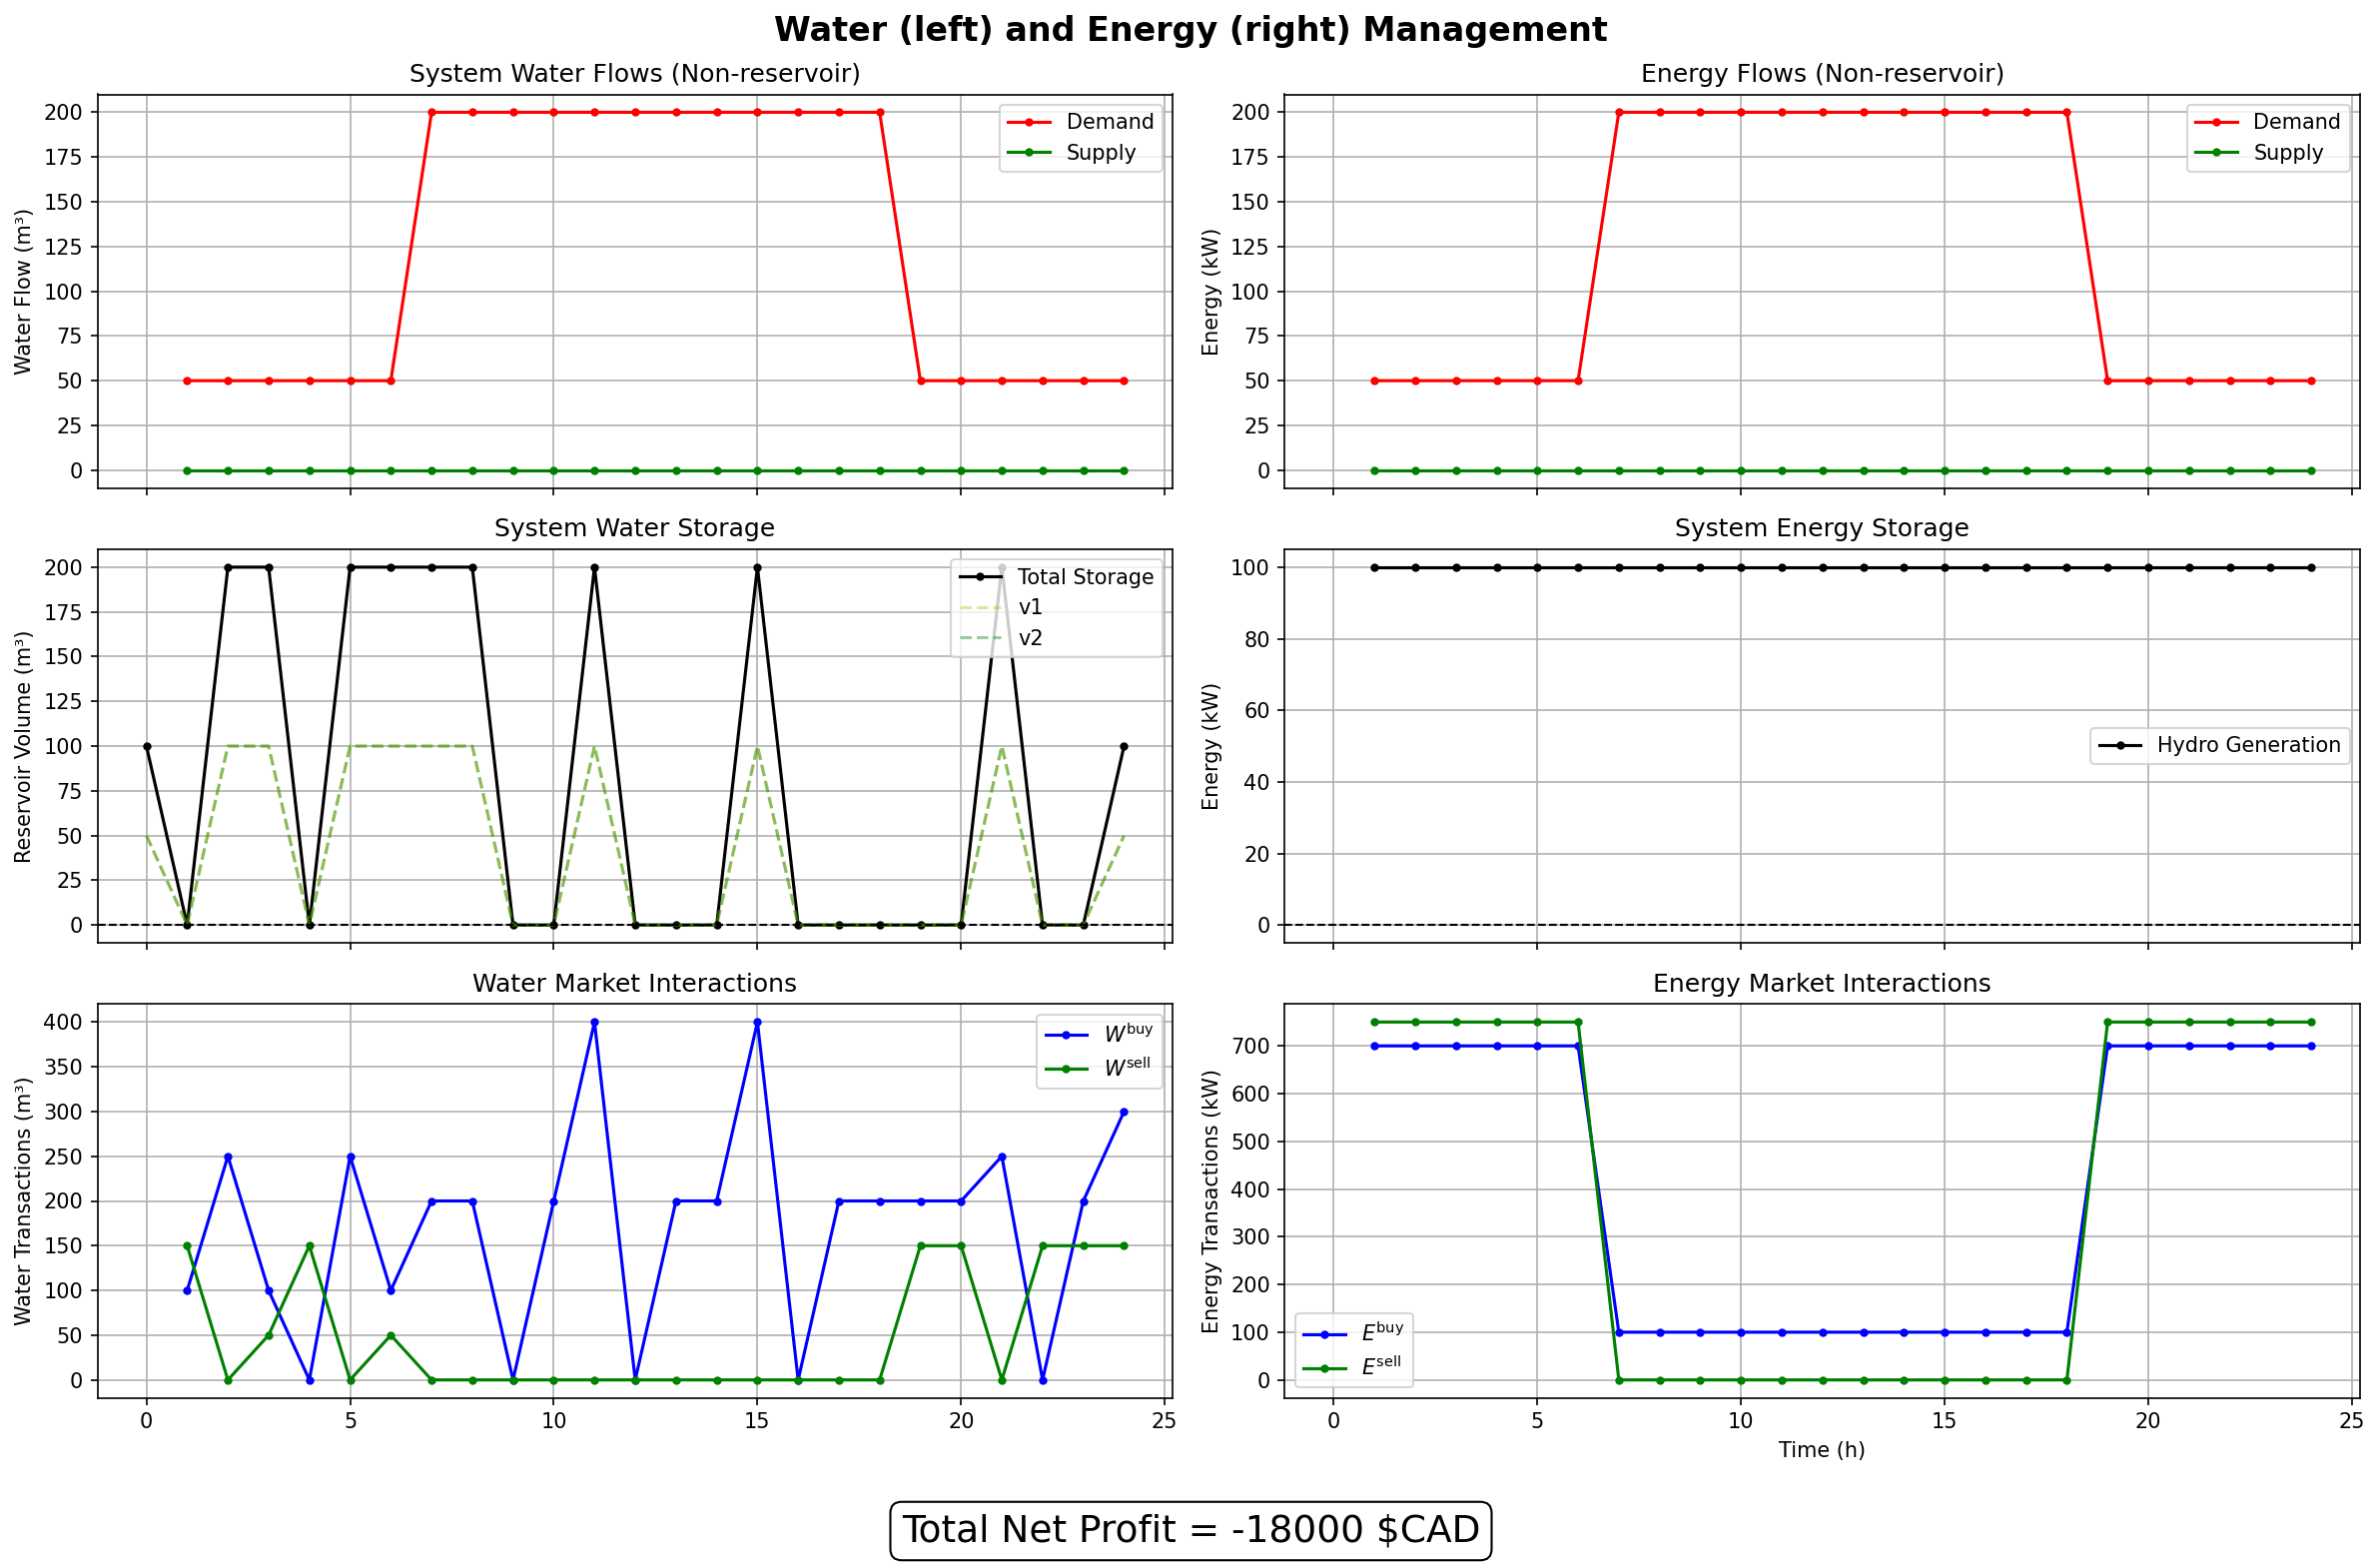

In [45]:
def scarcity_expectations(summary, model):
    eps = 1e-6
    return [
        ("Water purchases triggered under scarcity", summary["total_w_buy"] > eps),
        ("Energy purchases triggered under scarcity", summary["total_e_buy"] > eps),
        ("Terminal storage constraints respected", all(summary["final_volumes"][j] >= pyo.value(model.v_min[j]) - eps for j in model.J))
    ]

scarcity_overrides = {
    "rainfall_collection": {t: 0 for t in range(1, 25)},
    "wastewater_house": {t: 0 for t in range(1, 25)},
    "solar_house": {t: 0 for t in range(1, 25)},
    "turbine": {t: 0 for t in range(1, 25)}
}

scarcity_model, scarcity_results, scarcity_summary = run_edge_case(
    name="Scarcity",
    description="No exogenous inflows available; the system must rely on purchases.",
    overrides=scarcity_overrides,
    expectation_fn=scarcity_expectations
)

plot_results(scarcity_results, scarcity_model)

#### Surplus stress test
Increase exogenous water and energy supply. The model should respond by exporting surplus through sales once local limits are satisfied.



Surplus: Strong inflow and generation conditions encourage exports.


Solver termination: optimal
Total water bought: 400.00 m³
Total water sold: 2200.00 m³
Total energy bought: 3360.00 MWh
Total energy sold: 9480.00 MWh
Final reservoir volume v1: 50.00 m³ (min required 50.00)
Final reservoir volume v2: 50.00 m³ (min required 50.00)
 - Water sales triggered by surplus inflows: PASS
 - Energy sales triggered by surplus generation: PASS
 - Terminal storage constraints respected: PASS
Optimal solution found!
Objective value: 39600.00

=== SOLUTION SUMMARY ===

Reservoir Volumes (final):
v[v1, 24] = 50.00
v[v2, 24] = 50.00

Total Water Transactions:
Total Water Bought: 400.00
Total Water Sold: 2200.00

Total Energy Transactions:
Total Energy Bought: 3360.00
Total Energy Sold: 9480.00


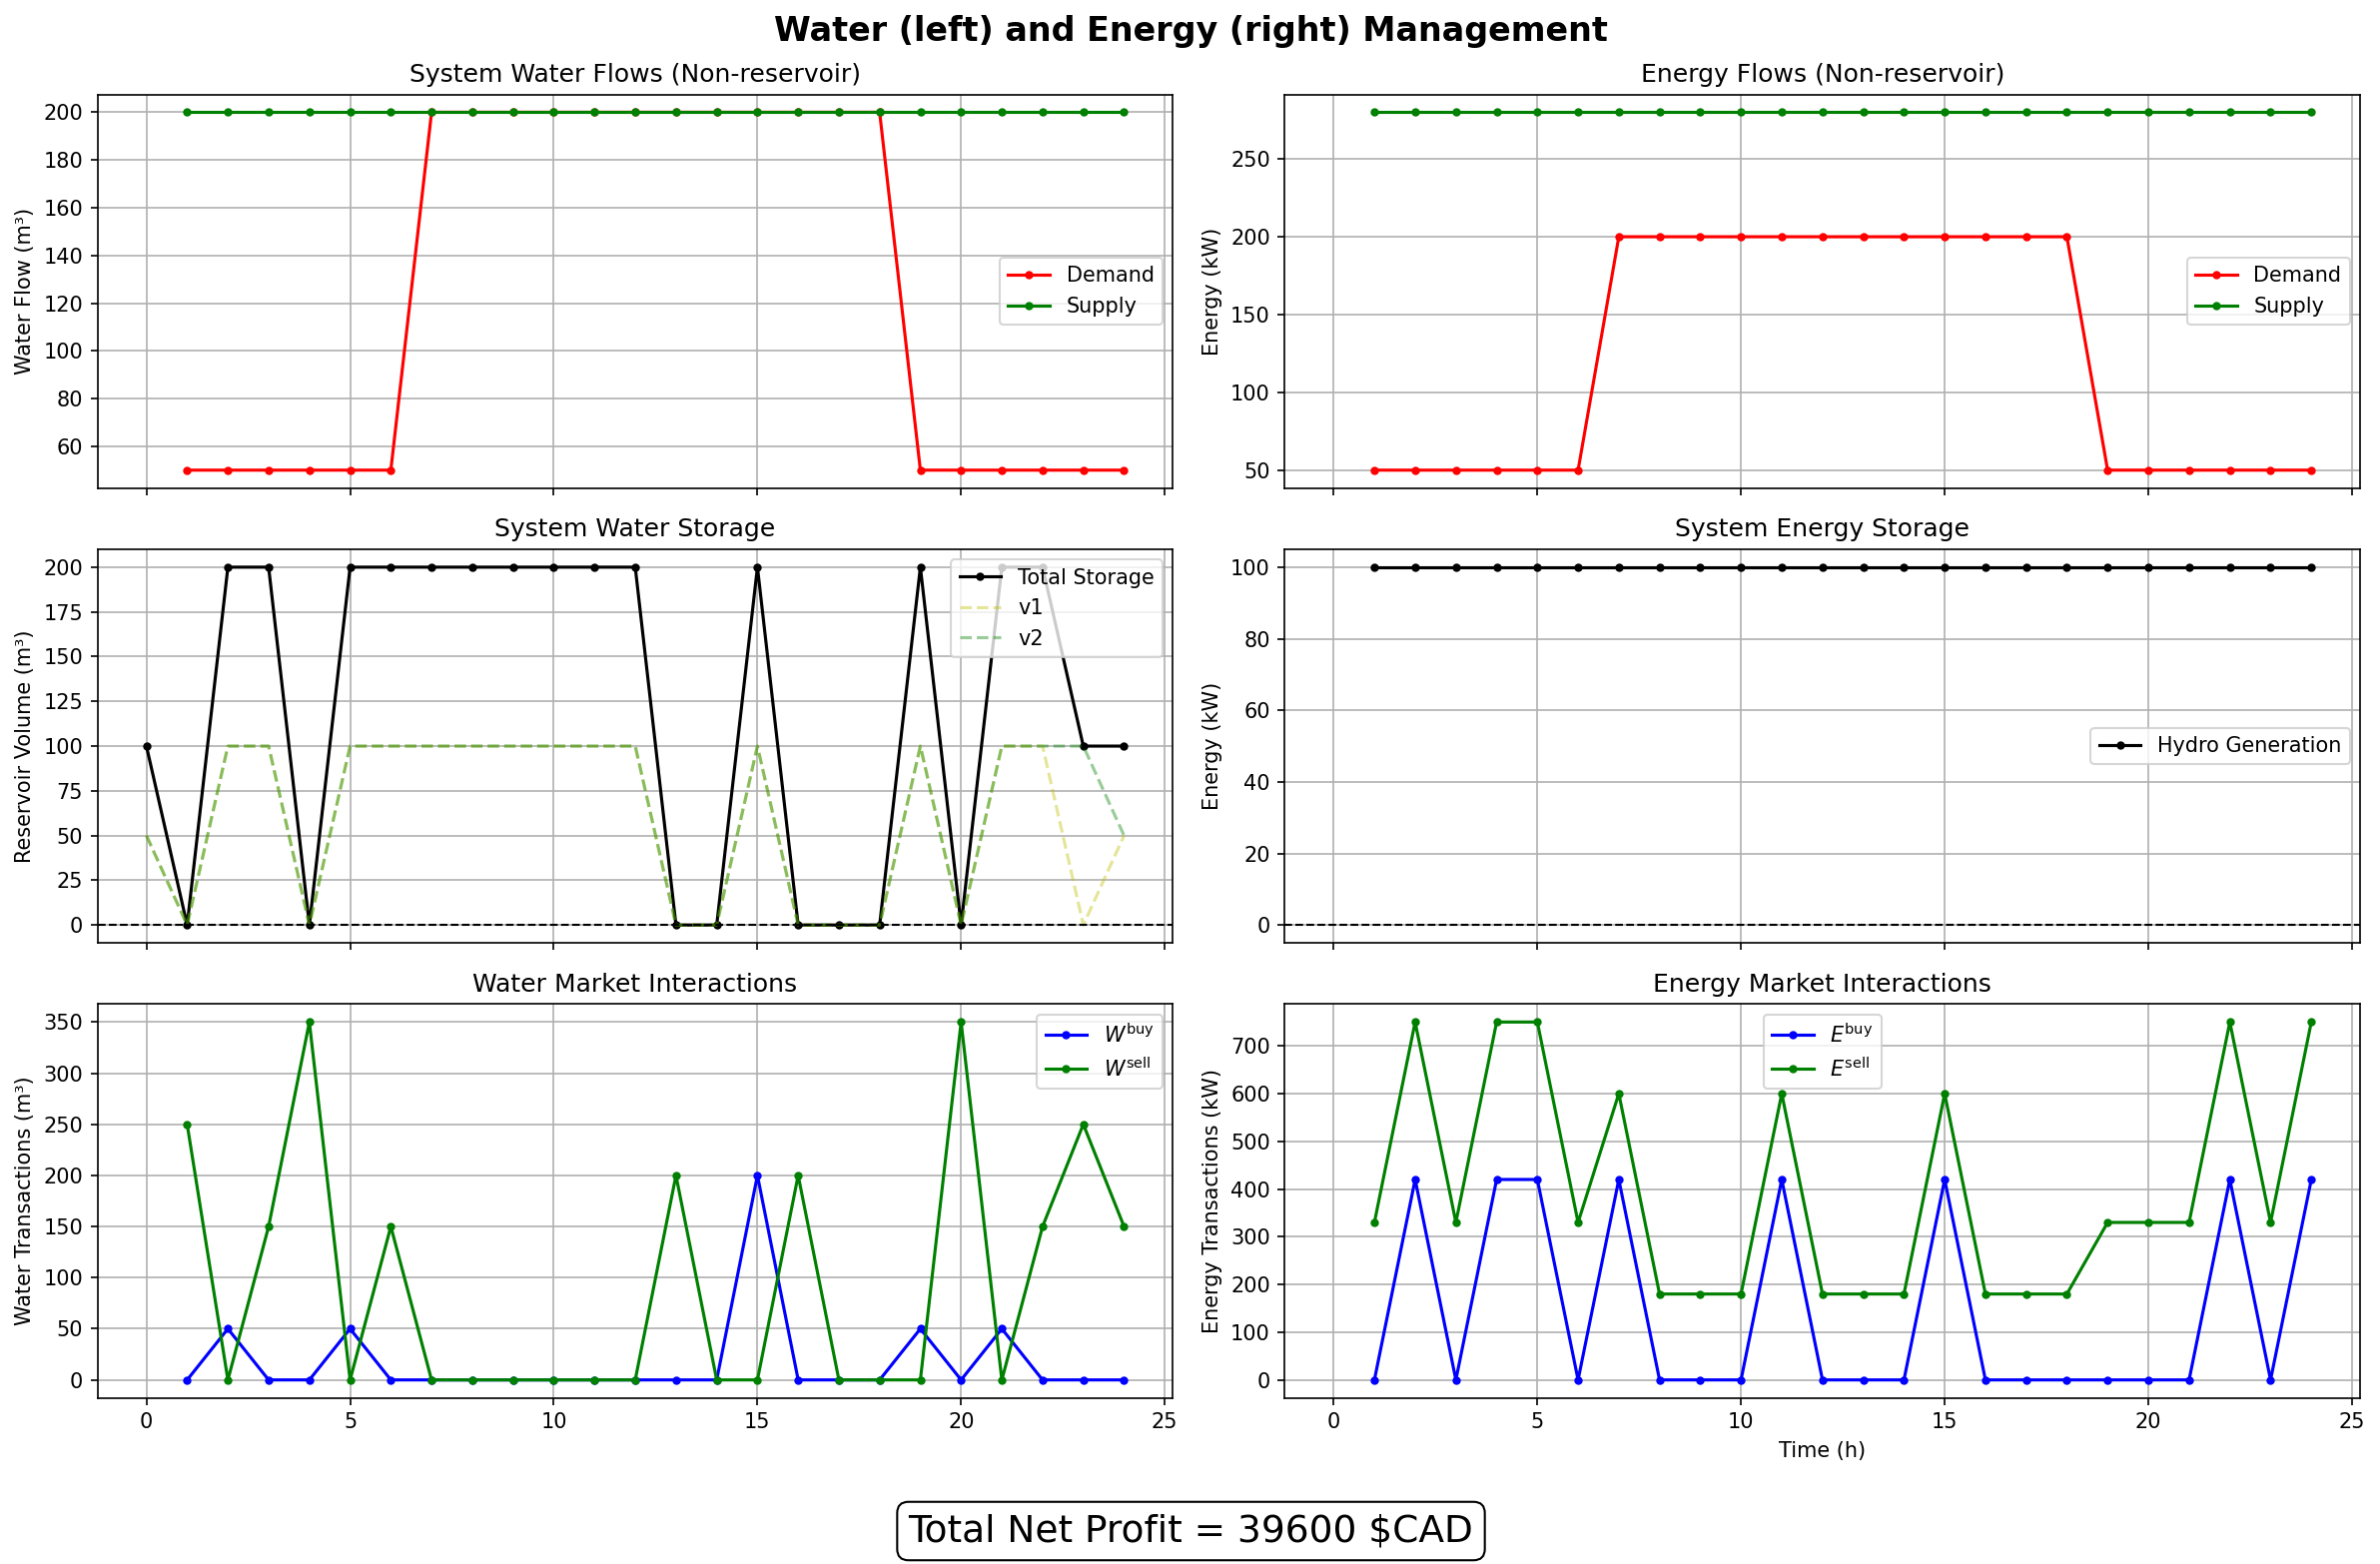

In [46]:
def surplus_expectations(summary, model):
    eps = 1e-6
    return [
        ("Water sales triggered by surplus inflows", summary["total_w_sell"] > eps),
        ("Energy sales triggered by surplus generation", summary["total_e_sell"] > eps),
        ("Terminal storage constraints respected", all(summary["final_volumes"][j] >= pyo.value(model.v_min[j]) - eps for j in model.J))
    ]

surplus_overrides = {
    "rainfall_collection": {t: 120 for t in range(1, 25)},
    "wastewater_house": {t: 80 for t in range(1, 25)},
    "solar_house": {t: 160 for t in range(1, 25)},
    "turbine": {t: 120 for t in range(1, 25)}
}

surplus_model, surplus_results, surplus_summary = run_edge_case(
    name="Surplus",
    description="Strong inflow and generation conditions encourage exports.",
    overrides=surplus_overrides,
    expectation_fn=surplus_expectations
)

plot_results(surplus_results, surplus_model)


#### Tight terminal storage test
Raise the terminal storage requirement while softening demand. The model should finish with both reservoirs at or above the tighter minimum volumes.



Tight storage: Higher terminal storage requirements must be met without violating bounds.
Solver termination: optimal
Total water bought: 630.00 m³
Total water sold: 2300.00 m³
Total energy bought: 9510.00 MWh
Total energy sold: 12630.00 MWh
Final reservoir volume v1: 95.00 m³ (min required 95.00)
Final reservoir volume v2: 95.00 m³ (min required 95.00)
 - Reservoir v1 satisfies tightened minimum: PASS
 - Reservoir v2 satisfies tightened minimum: PASS
Optimal solution found!
Objective value: 23950.00

=== SOLUTION SUMMARY ===

Reservoir Volumes (final):
v[v1, 24] = 95.00
v[v2, 24] = 95.00

Total Water Transactions:
Total Water Bought: 630.00
Total Water Sold: 2300.00

Total Energy Transactions:
Total Energy Bought: 9510.00
Total Energy Sold: 12630.00


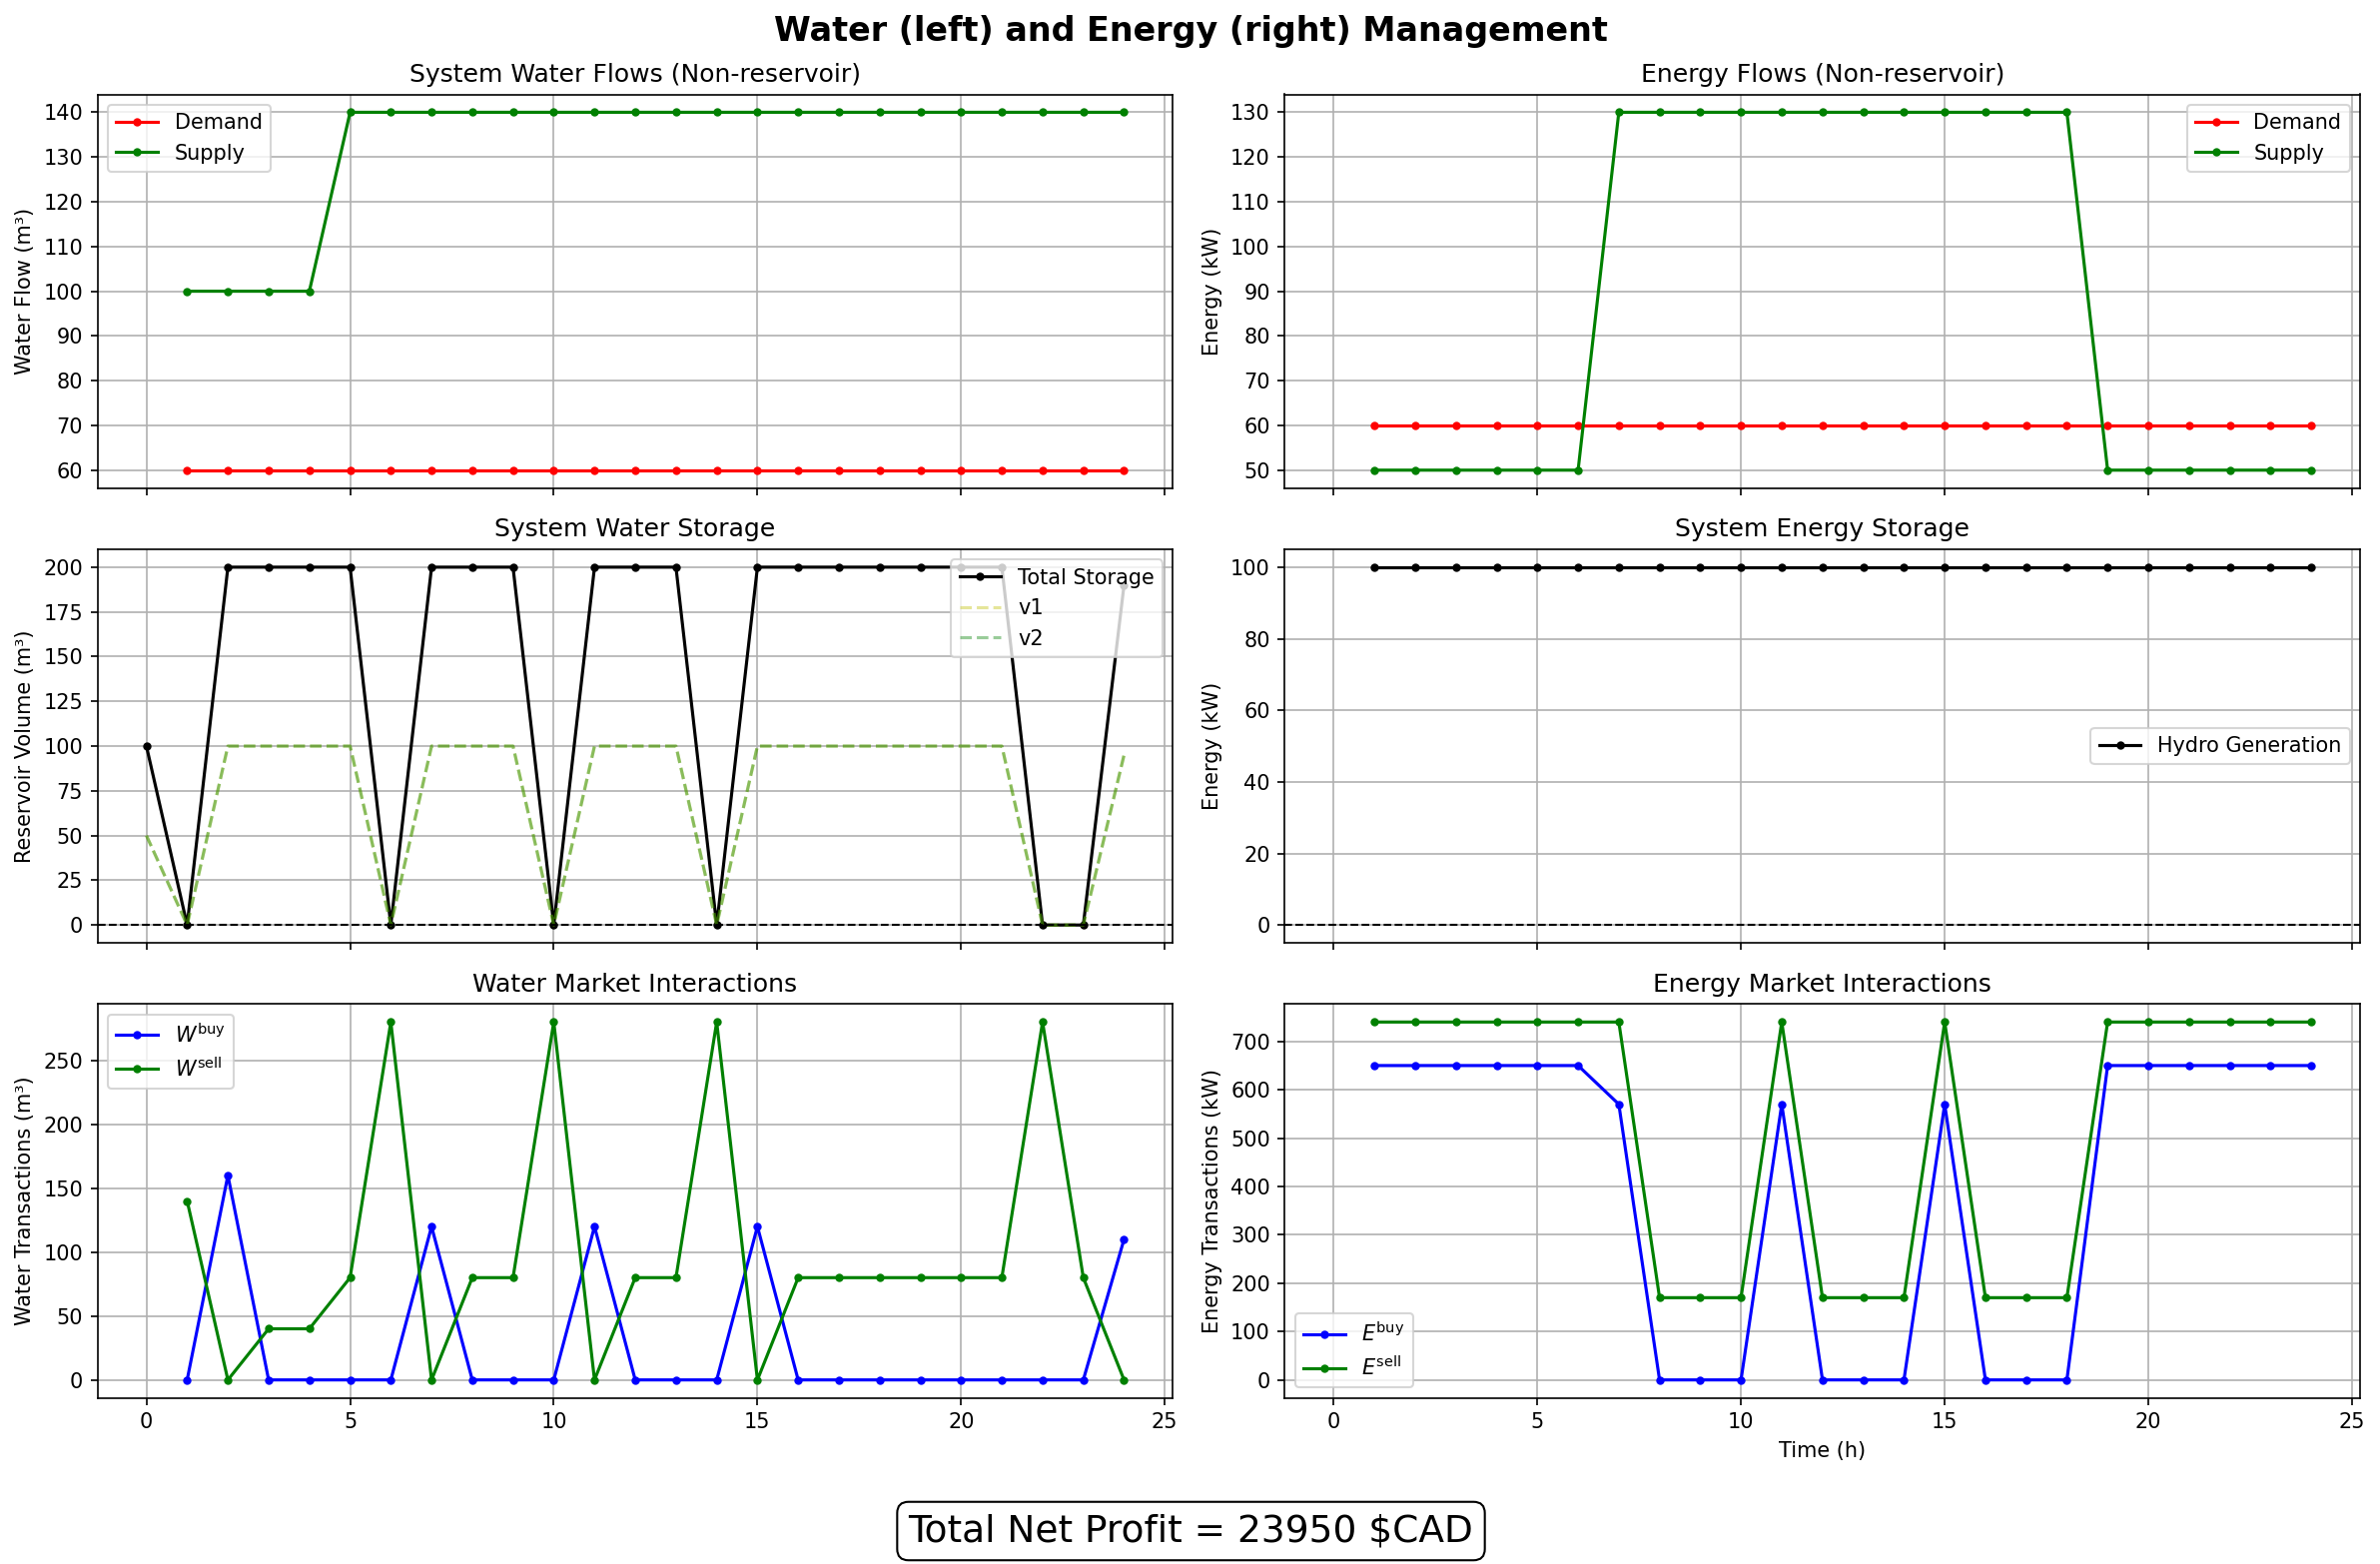

In [47]:
def tight_storage_expectations(summary, model):
    eps = 1e-6
    return [
        ("Reservoir v1 satisfies tightened minimum", summary["final_volumes"]["v1"] >= pyo.value(model.v_min["v1"]) - eps),
        ("Reservoir v2 satisfies tightened minimum", summary["final_volumes"]["v2"] >= pyo.value(model.v_min["v2"]) - eps)
    ]

tight_storage_overrides = {
    "v_min": {"v1": 95, "v2": 95},
    "demand_house": {t: 60 for t in range(1, 25)},
    "e_house": {t: 20 for t in range(1, 25)},
    "rainfall_collection": {t: 100 for t in range(1, 25)}
}

tight_storage_model, tight_storage_results, tight_storage_summary = run_edge_case(
    name="Tight storage",
    description="Higher terminal storage requirements must be met without violating bounds.",
    overrides=tight_storage_overrides,
    expectation_fn=tight_storage_expectations
)

plot_results(tight_storage_results, tight_storage_model)


#### Turbine outage stress test
Disable turbine-based hydro generation while keeping household demand unchanged. The model should shift to market purchases and avoid selling surplus energy.



Turbine outage: Hydro turbines unavailable; system must rely on imports.
Solver termination: optimal
Total water bought: 5290.00 m³
Total water sold: 3250.00 m³
Total energy bought: 2040.00 MWh
Total energy sold: 0.00 MWh
Final reservoir volume v1: 50.00 m³ (min required 50.00)
Final reservoir volume v2: 50.00 m³ (min required 50.00)
 - Energy purchases cover the outage: PASS
 - Energy exports are suppressed when turbines are offline: PASS
 - Terminal storage constraints respected: PASS
Optimal solution found!
Objective value: -20400.00

=== SOLUTION SUMMARY ===

Reservoir Volumes (final):
v[v1, 24] = 50.00
v[v2, 24] = 50.00

Total Water Transactions:
Total Water Bought: 5290.00
Total Water Sold: 3250.00

Total Energy Transactions:
Total Energy Bought: 2040.00
Total Energy Sold: 0.00


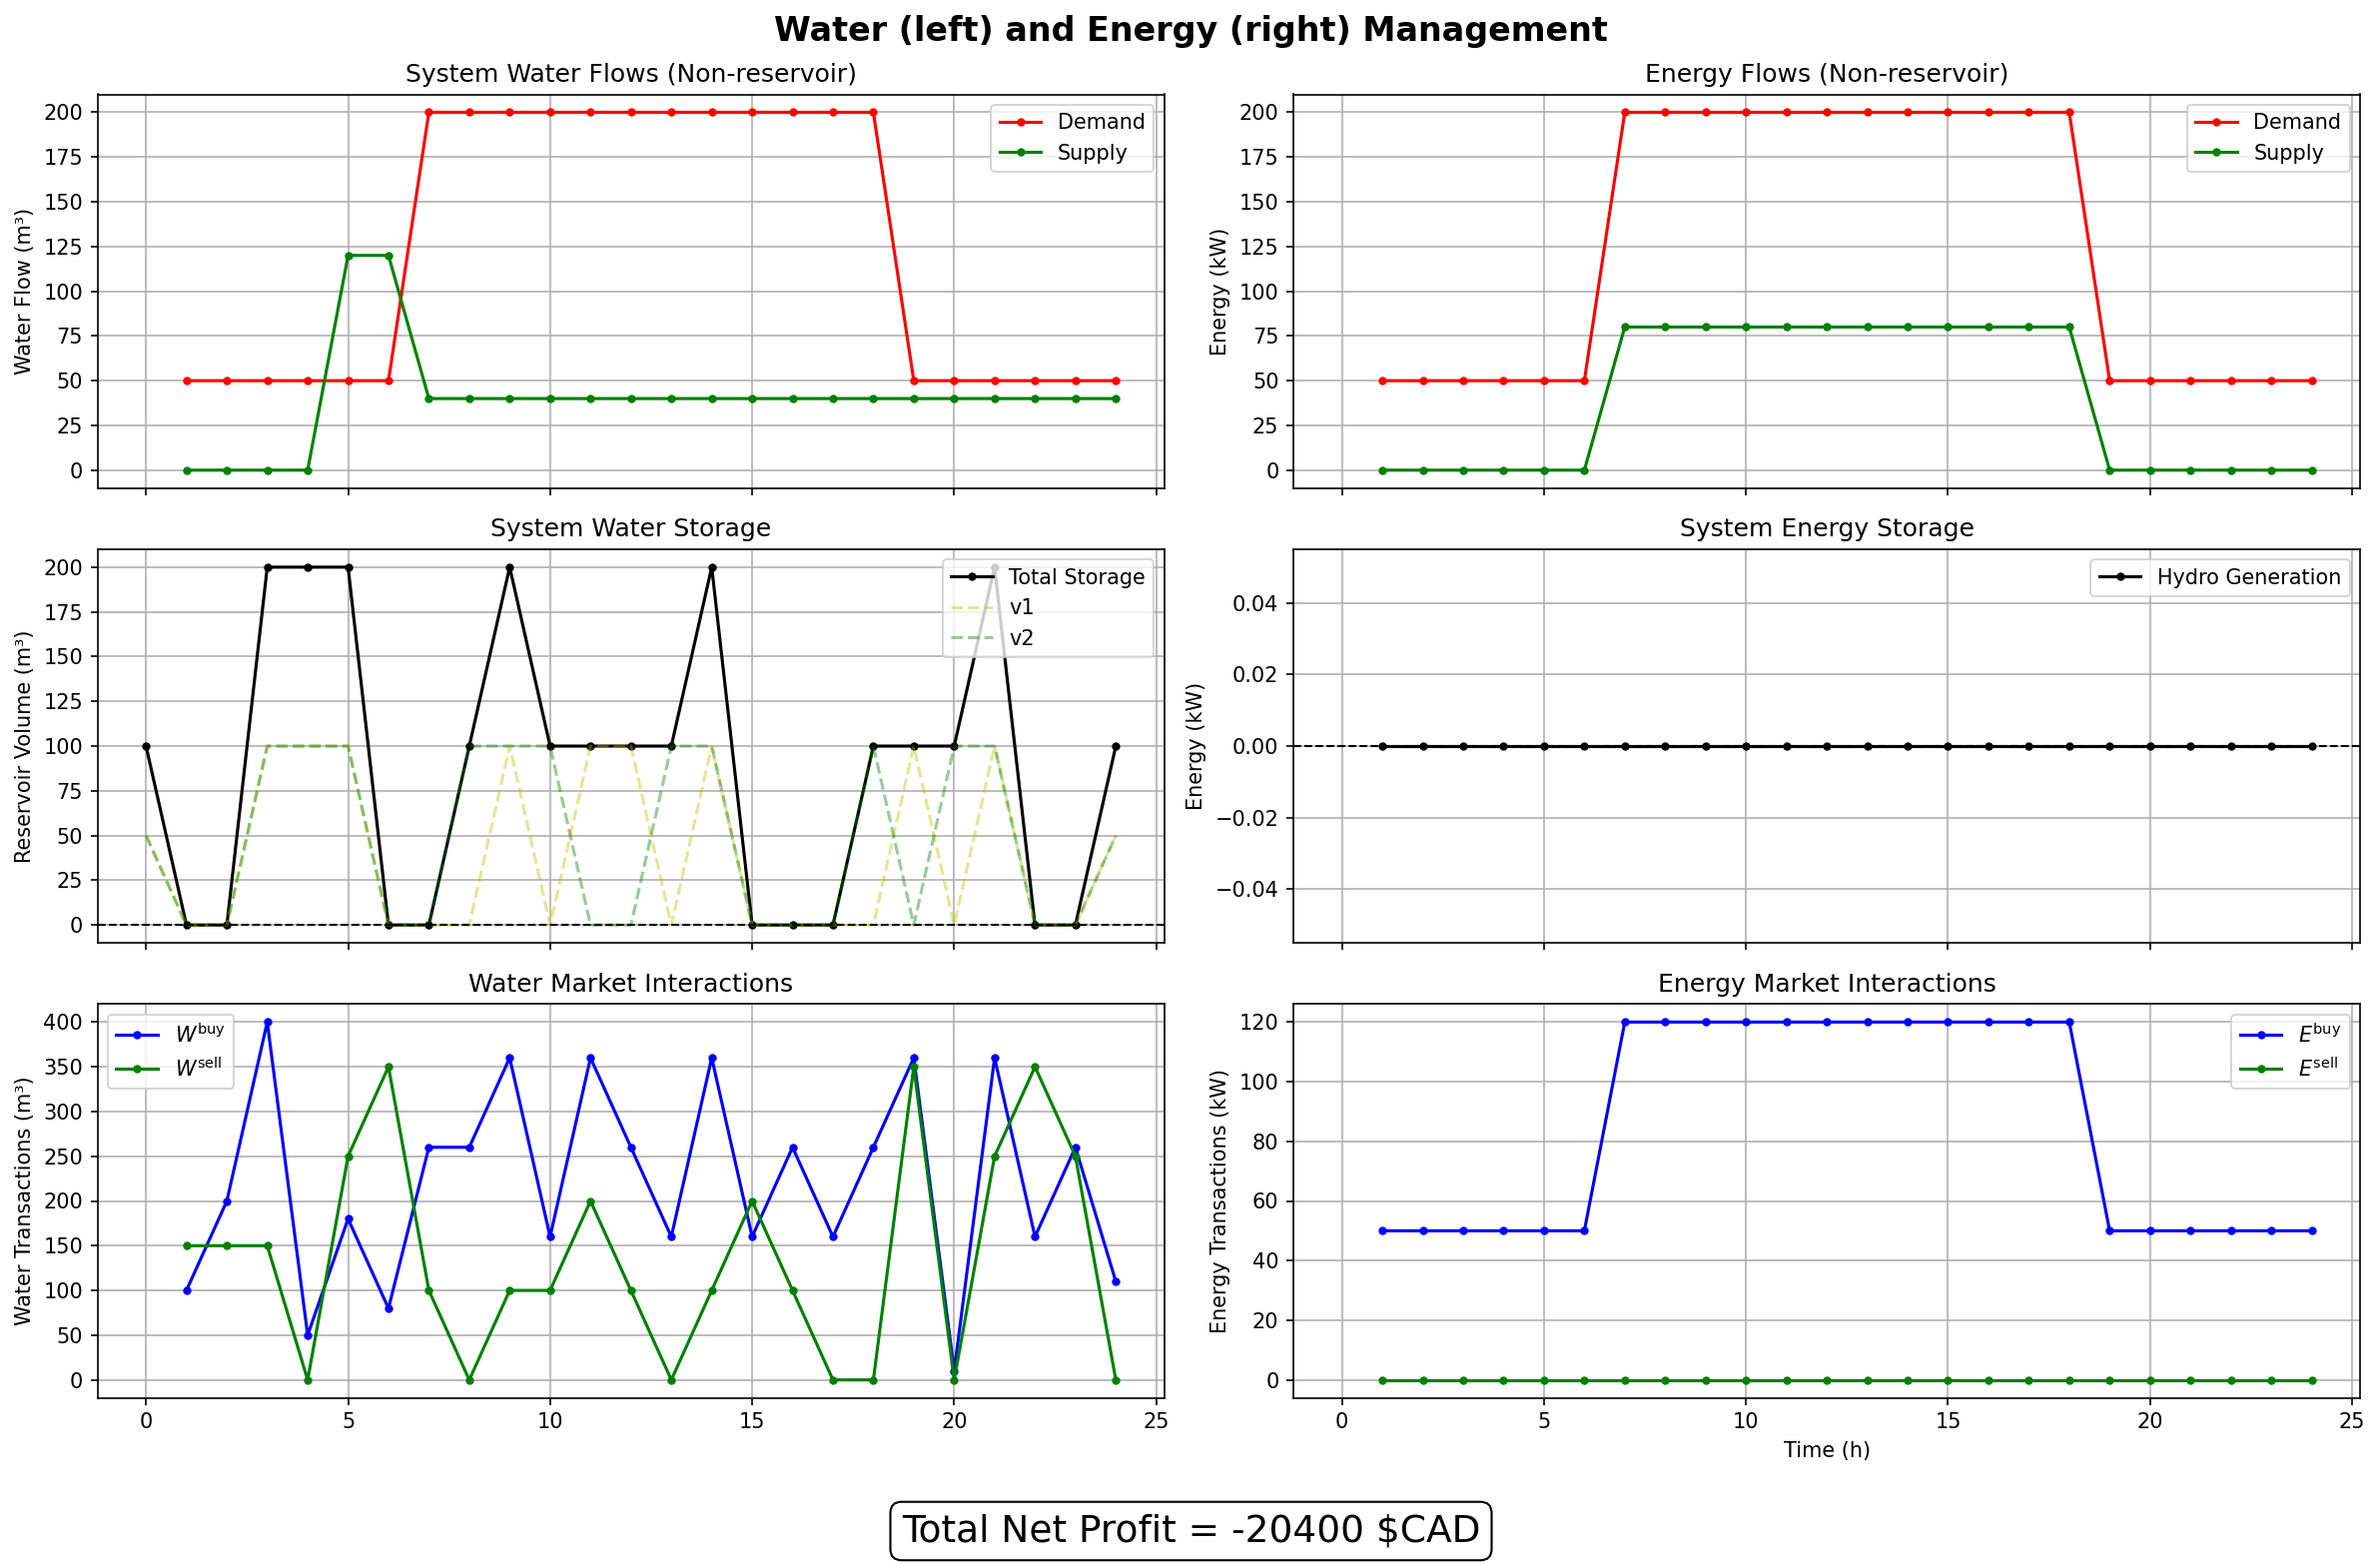

In [48]:
def turbine_outage_expectations(summary, model):
    eps = 1e-6
    return [
        ("Energy purchases cover the outage", summary['total_e_buy'] > eps),
        ("Energy exports are suppressed when turbines are offline", summary['total_e_sell'] < eps),
        ("Terminal storage constraints respected", all(summary['final_volumes'][j] >= pyo.value(model.v_min[j]) - eps for j in model.J))
    ]

turbine_outage_overrides = {
    'k': {'c_1_2': 0.0},
    'turbine': {t: 0 for t in range(1, 25)}
}

turbine_outage_model, turbine_outage_results, turbine_outage_summary = run_edge_case(
    name='Turbine outage',
    description='Hydro turbines unavailable; system must rely on imports.',
    overrides=turbine_outage_overrides,
    expectation_fn=turbine_outage_expectations
)

plot_results(turbine_outage_results, turbine_outage_model)


#### Inter-reservoir bottleneck test
Reduce inter-reservoir transfer capacities to confirm the associated limits bind and prompt additional market activity.



Inter-reservoir bottleneck: Tighter inter-reservoir transfer limits force reliance on markets.
Solver termination: optimal
Total water bought: 1840.00 m³
Total water sold: 1080.00 m³
Total energy bought: 7040.00 MWh
Total energy sold: 6128.00 MWh
Final reservoir volume v1: 50.00 m³ (min required 50.00)
Final reservoir volume v2: 50.00 m³ (min required 50.00)
 - At least one inter-reservoir flow hits its capacity: PASS
 - Market activity compensates for the bottleneck: PASS
 - Terminal storage constraints respected: PASS
Optimal solution found!
Objective value: -8360.00

=== SOLUTION SUMMARY ===

Reservoir Volumes (final):
v[v1, 24] = 50.00
v[v2, 24] = 50.00

Total Water Transactions:
Total Water Bought: 1840.00
Total Water Sold: 1080.00

Total Energy Transactions:
Total Energy Bought: 7040.00
Total Energy Sold: 6128.00


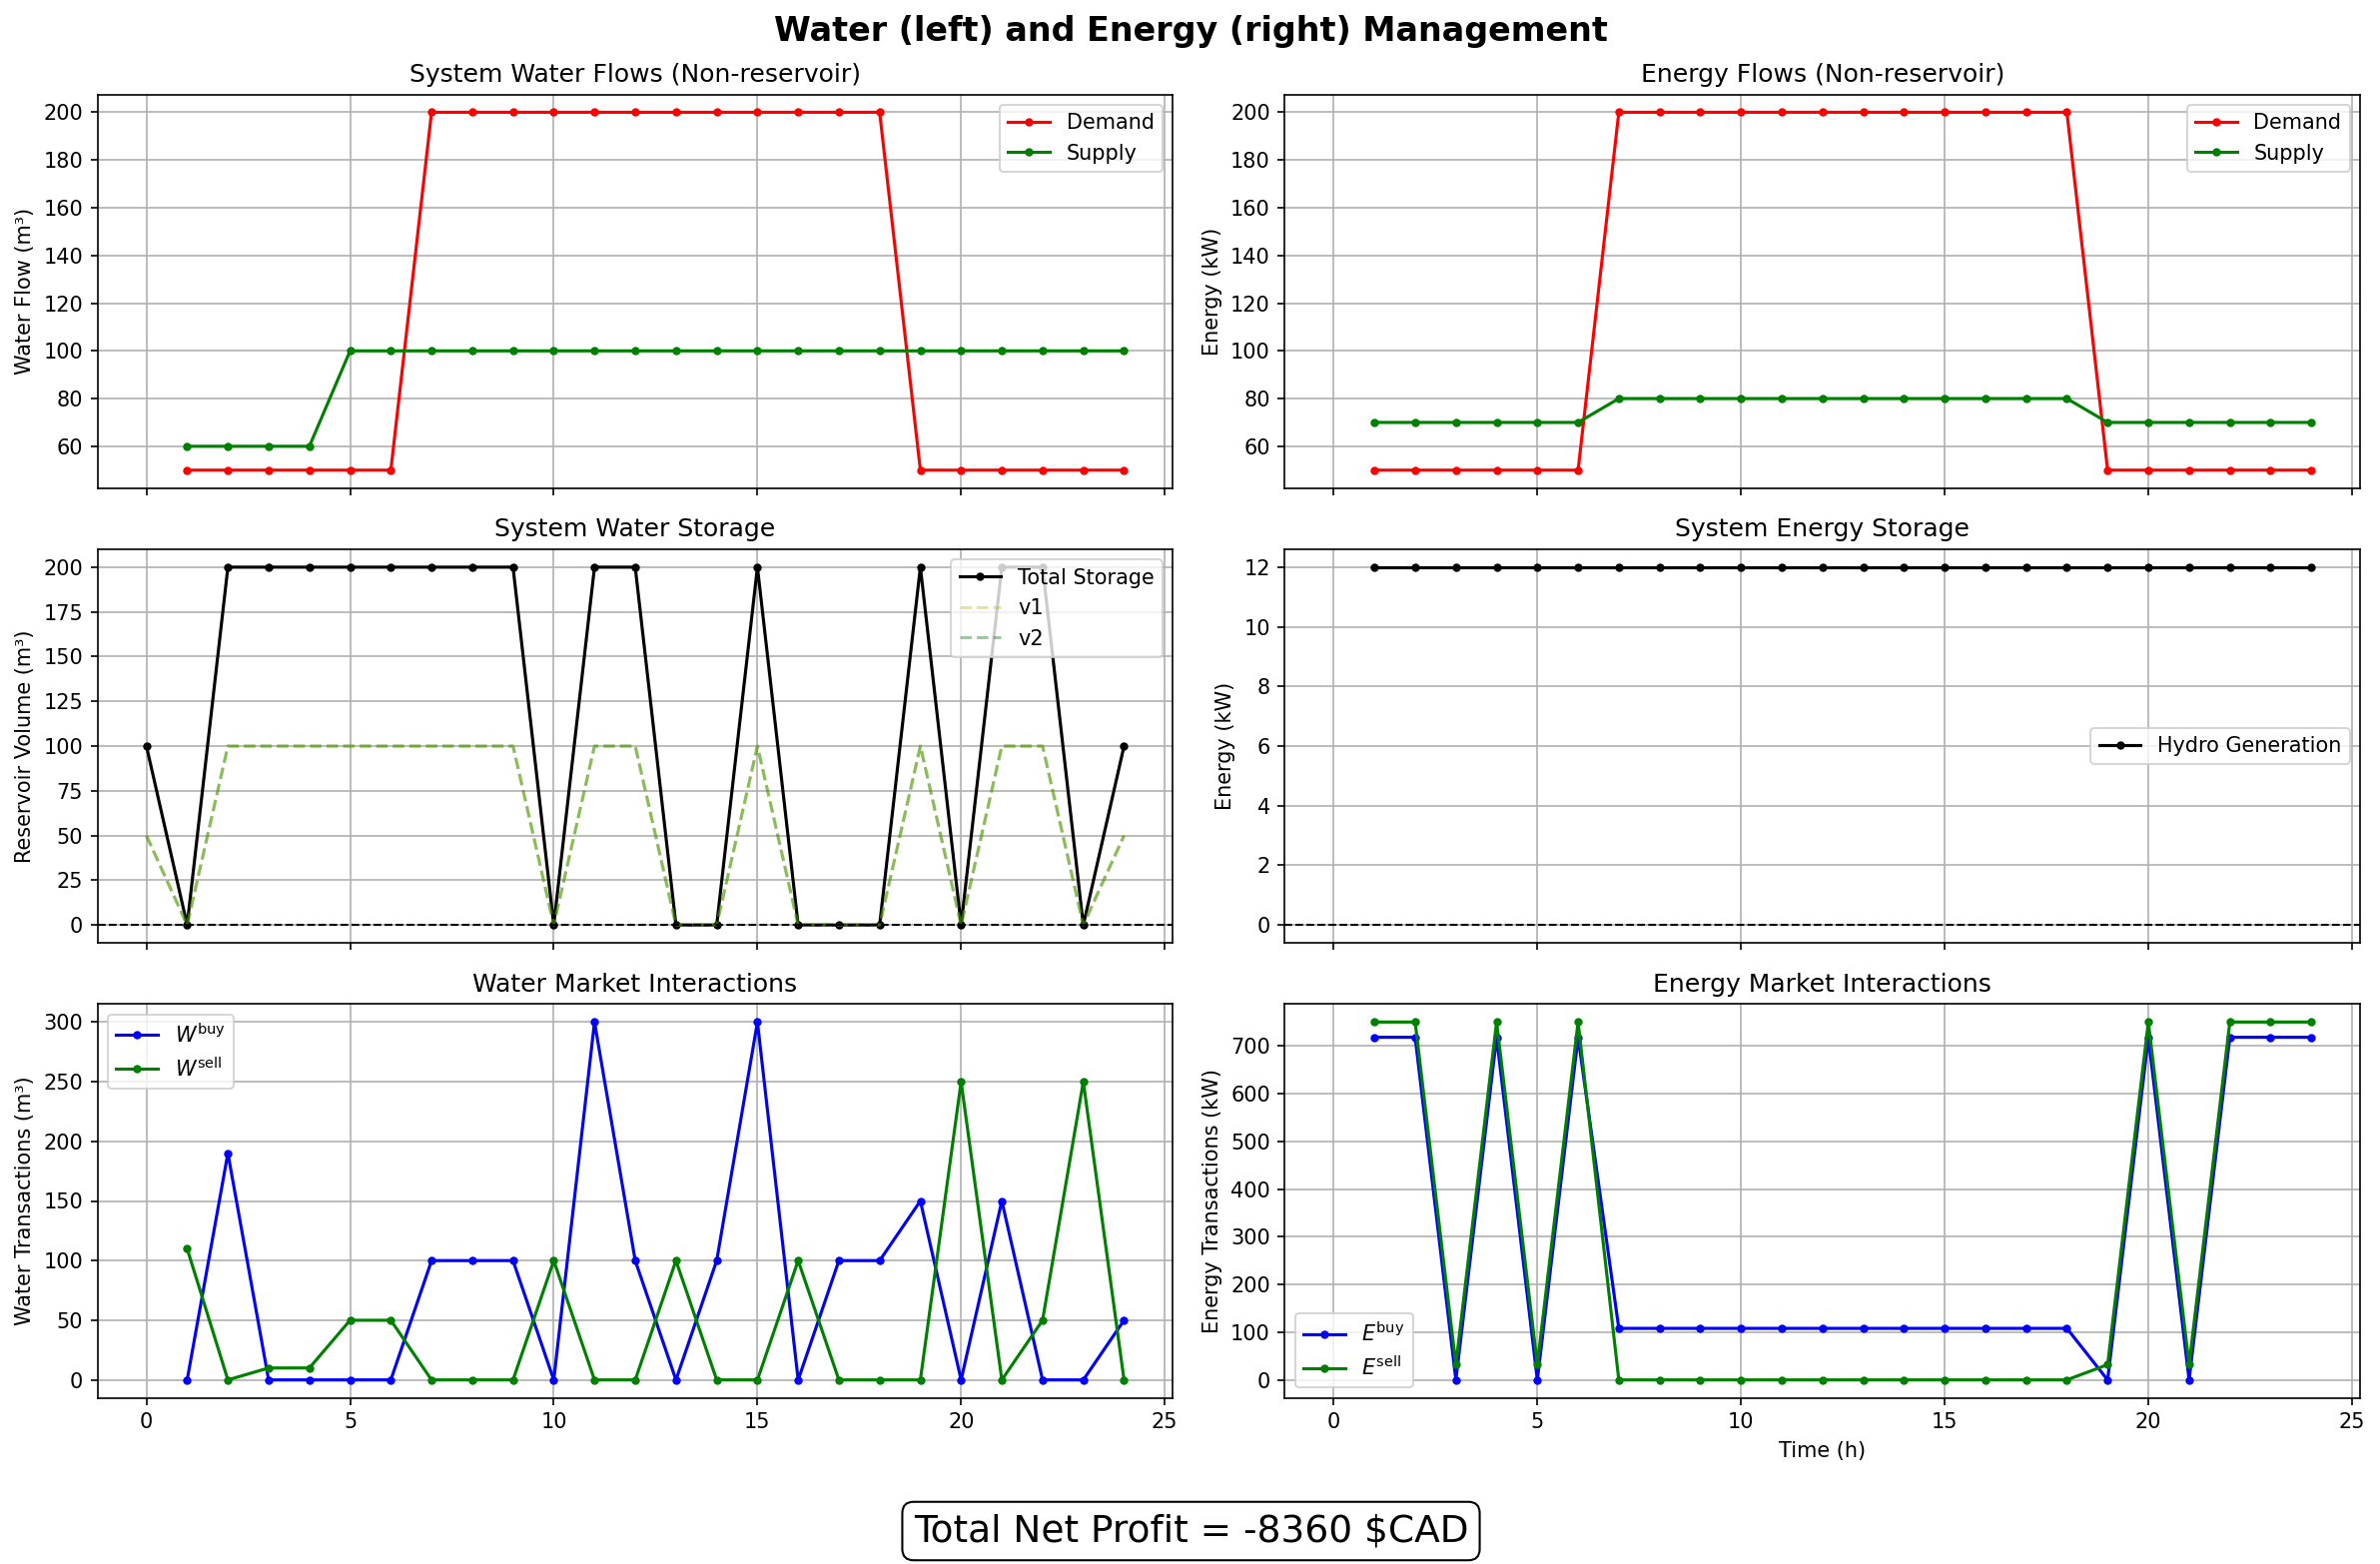

In [49]:
def bottleneck_expectations(summary, model):
    eps = 1e-6
    flow_binding = False
    for i in model.I:
        q_max = pyo.value(model.q_max_i[i])
        max_used = max(pyo.value(model.q_i[i, t]) for t in model.T)
        if abs(max_used - q_max) <= 1e-3:
            flow_binding = True
            break
    return [
        ("At least one inter-reservoir flow hits its capacity", flow_binding),
        ("Market activity compensates for the bottleneck", summary['total_w_buy'] > eps or summary['total_e_buy'] > eps),
        ("Terminal storage constraints respected", all(summary['final_volumes'][j] >= pyo.value(model.v_min[j]) - eps for j in model.J))
    ]

bottleneck_overrides = {
    'q_max_i': {'c_1_2': 12, 'c_2_1': 8},
    'rainfall_collection': {t: 60 for t in range(1, 25)},
    'solar_house': {t: 30 if 7 <= t <= 18 else 20 for t in range(1, 25)}
}

bottleneck_model, bottleneck_results, bottleneck_summary = run_edge_case(
    name='Inter-reservoir bottleneck',
    description='Tighter inter-reservoir transfer limits force reliance on markets.',
    overrides=bottleneck_overrides,
    expectation_fn=bottleneck_expectations
)

plot_results(bottleneck_results, bottleneck_model)


#### Price arbitrage stress test
Alter market prices to favor exports and verify that the model increases sales while avoiding expensive imports.



Price arbitrage: High selling price and cheap purchases encourage exports over imports.
Solver termination: optimal
Total water bought: 4350.00 m³
Total water sold: 5750.00 m³
Total energy bought: 9200.00 MWh
Total energy sold: 14120.00 MWh
Final reservoir volume v1: 50.00 m³ (min required 50.00)
Final reservoir volume v2: 50.00 m³ (min required 50.00)
 - Water sales become profitable: PASS
 - Energy sales become profitable: PASS
 - Expensive imports are avoided: PASS
Optimal solution found!
Objective value: 195990.00

=== SOLUTION SUMMARY ===

Reservoir Volumes (final):
v[v1, 24] = 50.00
v[v2, 24] = 50.00

Total Water Transactions:
Total Water Bought: 4350.00
Total Water Sold: 5750.00

Total Energy Transactions:
Total Energy Bought: 9200.00
Total Energy Sold: 14120.00


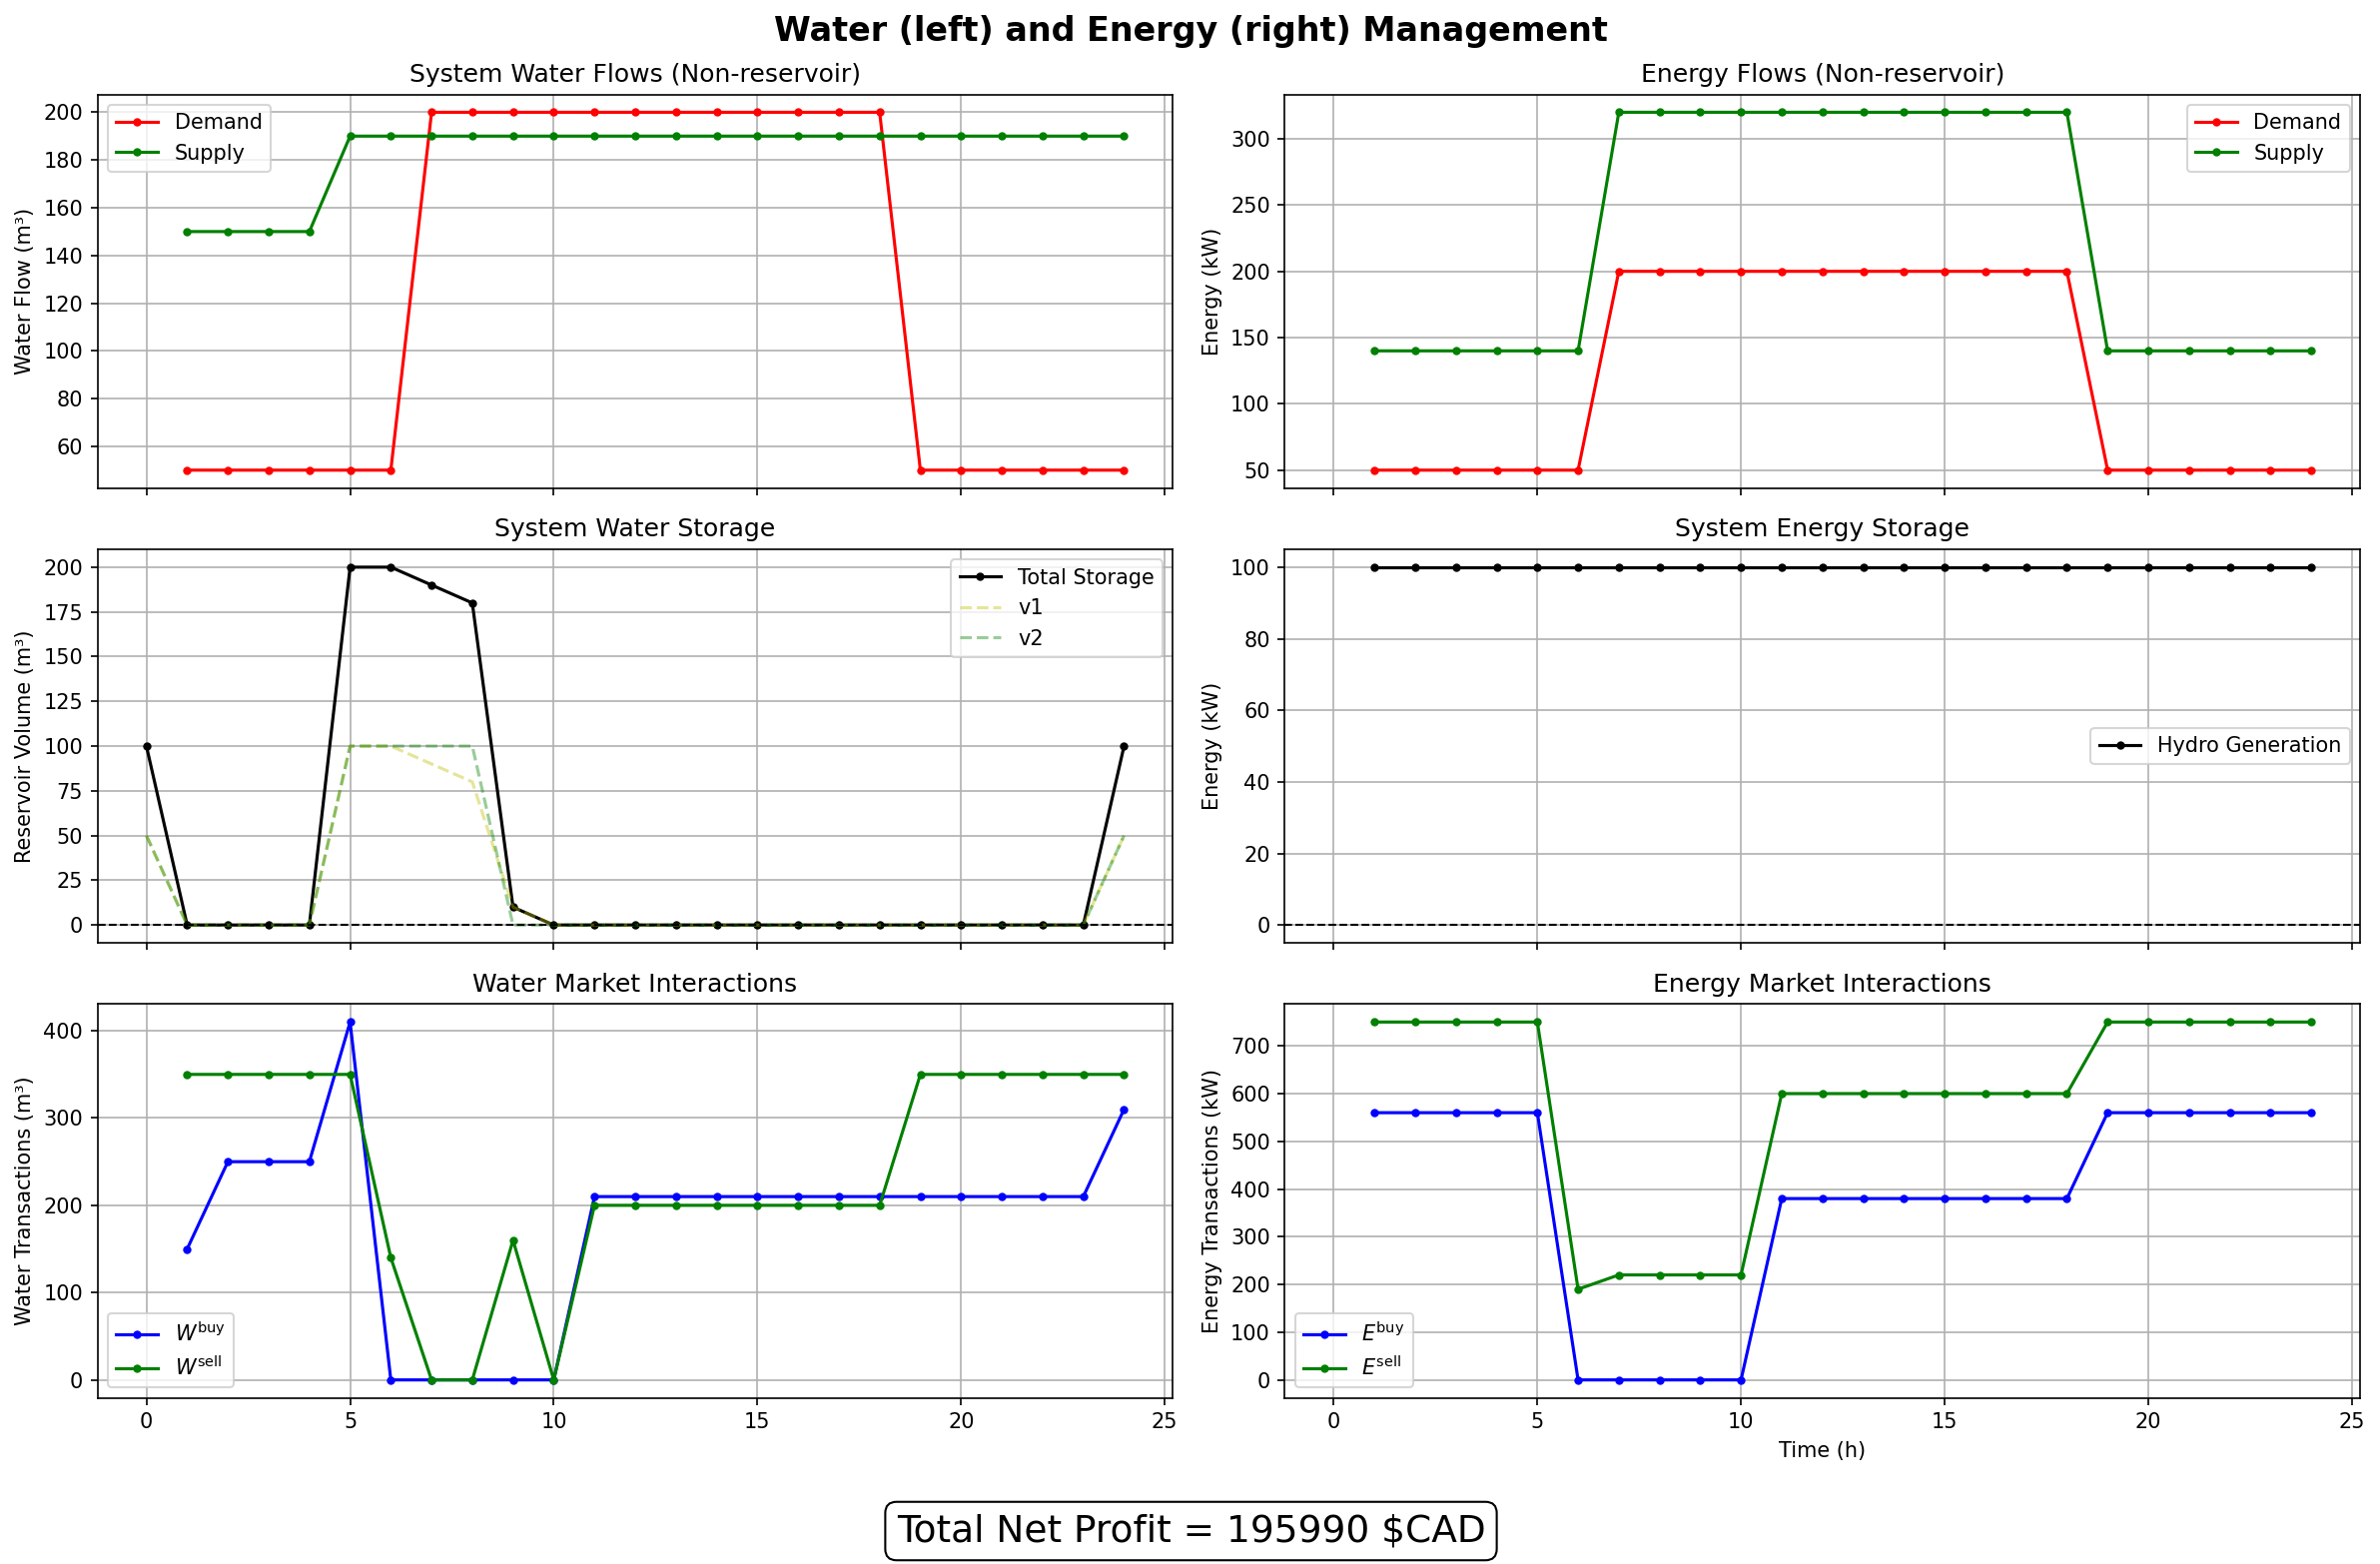

In [50]:
def price_arbitrage_expectations(summary, model):
    w_buy_during_high_purchase = np.array([pyo.value(model.W_buy[t]) for t in range(6, 11)])
    e_buy_during_high_purchase = np.array([pyo.value(model.E_buy[t]) for t in range(6, 11)])
    eps = 1e-6
    return [
        ("Water sales become profitable", summary['total_w_sell'] > summary['total_w_buy']),
        ("Energy sales become profitable", summary['total_e_sell'] > summary['total_e_buy']),
        ("Expensive imports are avoided", all(w_buy_during_high_purchase < eps) and all(e_buy_during_high_purchase < eps))
    ]

price_arbitrage_overrides = {
    'lambda_t': {t: 10 for t in range(1, 25)},
    'mu_t': {t: 100 if 6 <= t <= 10 else 0.2 for t in range(1, 25)},
    'rainfall_collection': {t: 150 for t in range(1, 25)},
    'solar_house': {t: 200 if 7 <= t <= 18 else 20 for t in range(1, 25)},
    'turbine': {t: 120 for t in range(1, 25)}
}

price_arbitrage_model, price_arbitrage_results, price_arbitrage_summary = run_edge_case(
    name='Price arbitrage',
    description='High selling price and cheap purchases encourage exports over imports.',
    overrides=price_arbitrage_overrides,
    expectation_fn=price_arbitrage_expectations
)

plot_results(price_arbitrage_results, price_arbitrage_model)

#### Demand surge stress test
Scale up both water and electricity demand to stress buying decisions. The model should rely heavily on market purchases while avoiding exports.



Demand surge: High simultaneous water and electricity demand.
Solver termination: optimal
Total water bought: 3420.00 m³
Total water sold: 1240.00 m³
Total energy bought: 7260.00 MWh
Total energy sold: 7380.00 MWh
Final reservoir volume v1: 50.00 m³ (min required 50.00)
Final reservoir volume v2: 50.00 m³ (min required 50.00)
 - Water purchases ramp up during the surge: PASS
 - Energy purchases ramp up during the surge: PASS
 - Sales remain negligible under high demand: CHECK
 - Terminal storage constraints respected: PASS
Optimal solution found!
Objective value: -10300.00

=== SOLUTION SUMMARY ===

Reservoir Volumes (final):
v[v1, 24] = 50.00
v[v2, 24] = 50.00

Total Water Transactions:
Total Water Bought: 3420.00
Total Water Sold: 1240.00

Total Energy Transactions:
Total Energy Bought: 7260.00
Total Energy Sold: 7380.00


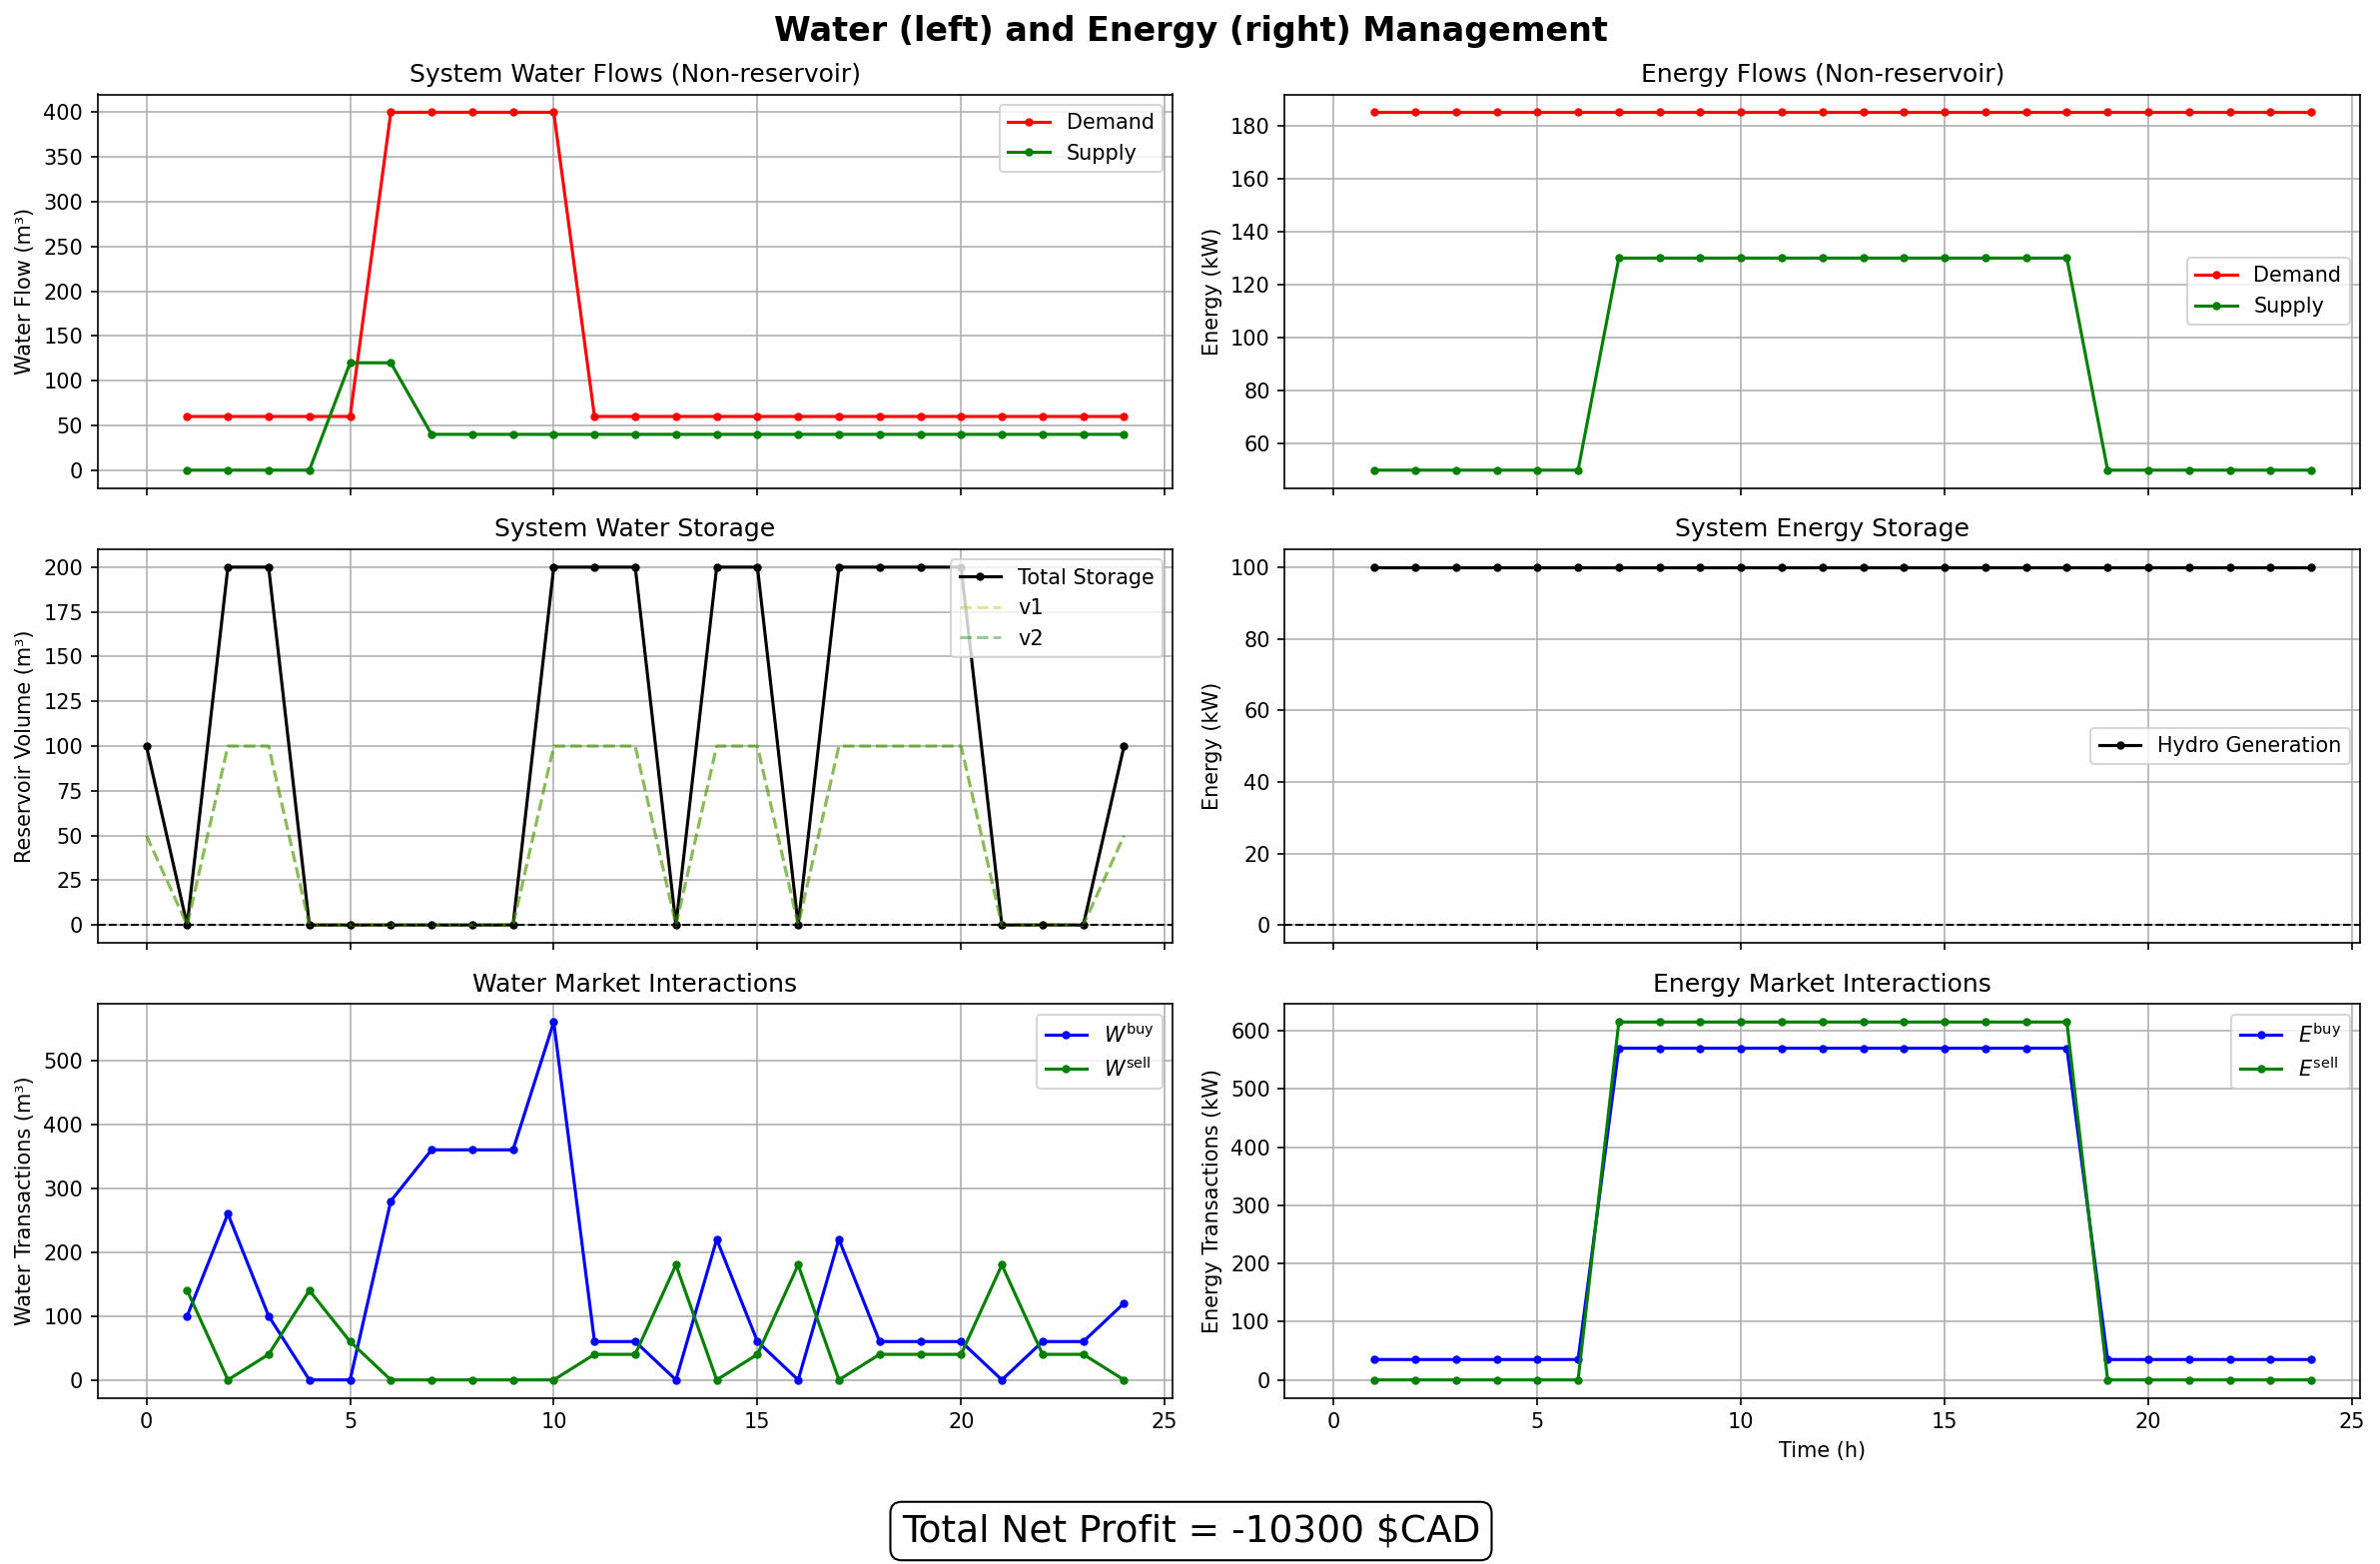

In [51]:
def demand_surge_expectations(summary, model):
    eps = 1e-6
    return [
        ("Water purchases ramp up during the surge", summary['total_w_buy'] > 500.0),
        ("Energy purchases ramp up during the surge", summary['total_e_buy'] > 500.0),
        ("Sales remain negligible under high demand", summary['total_w_sell'] < eps and summary['total_e_sell'] < eps),
        ("Terminal storage constraints respected", all(summary['final_volumes'][j] >= pyo.value(model.v_min[j]) - eps for j in model.J))
    ]

demand_surge_overrides = {
    'demand_house': {t: 400 if 6 <= t <= 10 else 60  for t in range(1, 25)},
    'e_house': {t: 120 for t in range(1, 25)},
    'e_treatment': {t: 40 for t in range(1, 25)},
    'e_distribution': {t: 25 for t in range(1, 25)}
}

demand_surge_model, demand_surge_results, demand_surge_summary = run_edge_case(
    name='Demand surge',
    description='High simultaneous water and electricity demand.',
    overrides=demand_surge_overrides,
    expectation_fn=demand_surge_expectations
)

plot_results(demand_surge_results, demand_surge_model)

#### Pumping-dominant operation test
Flip inter-reservoir coefficients to emphasize pumping (energy consumption) and confirm the system compensates with additional electricity purchases.



Pumping dominant: Inter-reservoir transfers act as pumps only.
Solver termination: optimal
Total water bought: 1950.00 m³
Total water sold: 710.00 m³
Total energy bought: 840.00 MWh
Total energy sold: 0.00 MWh
Final reservoir volume v1: 50.00 m³ (min required 50.00)
Final reservoir volume v2: 50.00 m³ (min required 50.00)
 - Net hydro operation consumes energy: CHECK
 - Energy purchases rise to feed pumps: PASS
 - Reservoir volumes stay within limits: PASS
 - Terminal storage constraints respected: PASS
Optimal solution found!
Objective value: -10400.00

=== SOLUTION SUMMARY ===

Reservoir Volumes (final):
v[v1, 24] = 50.00
v[v2, 24] = 50.00

Total Water Transactions:
Total Water Bought: 1950.00
Total Water Sold: 710.00

Total Energy Transactions:
Total Energy Bought: 840.00
Total Energy Sold: 0.00


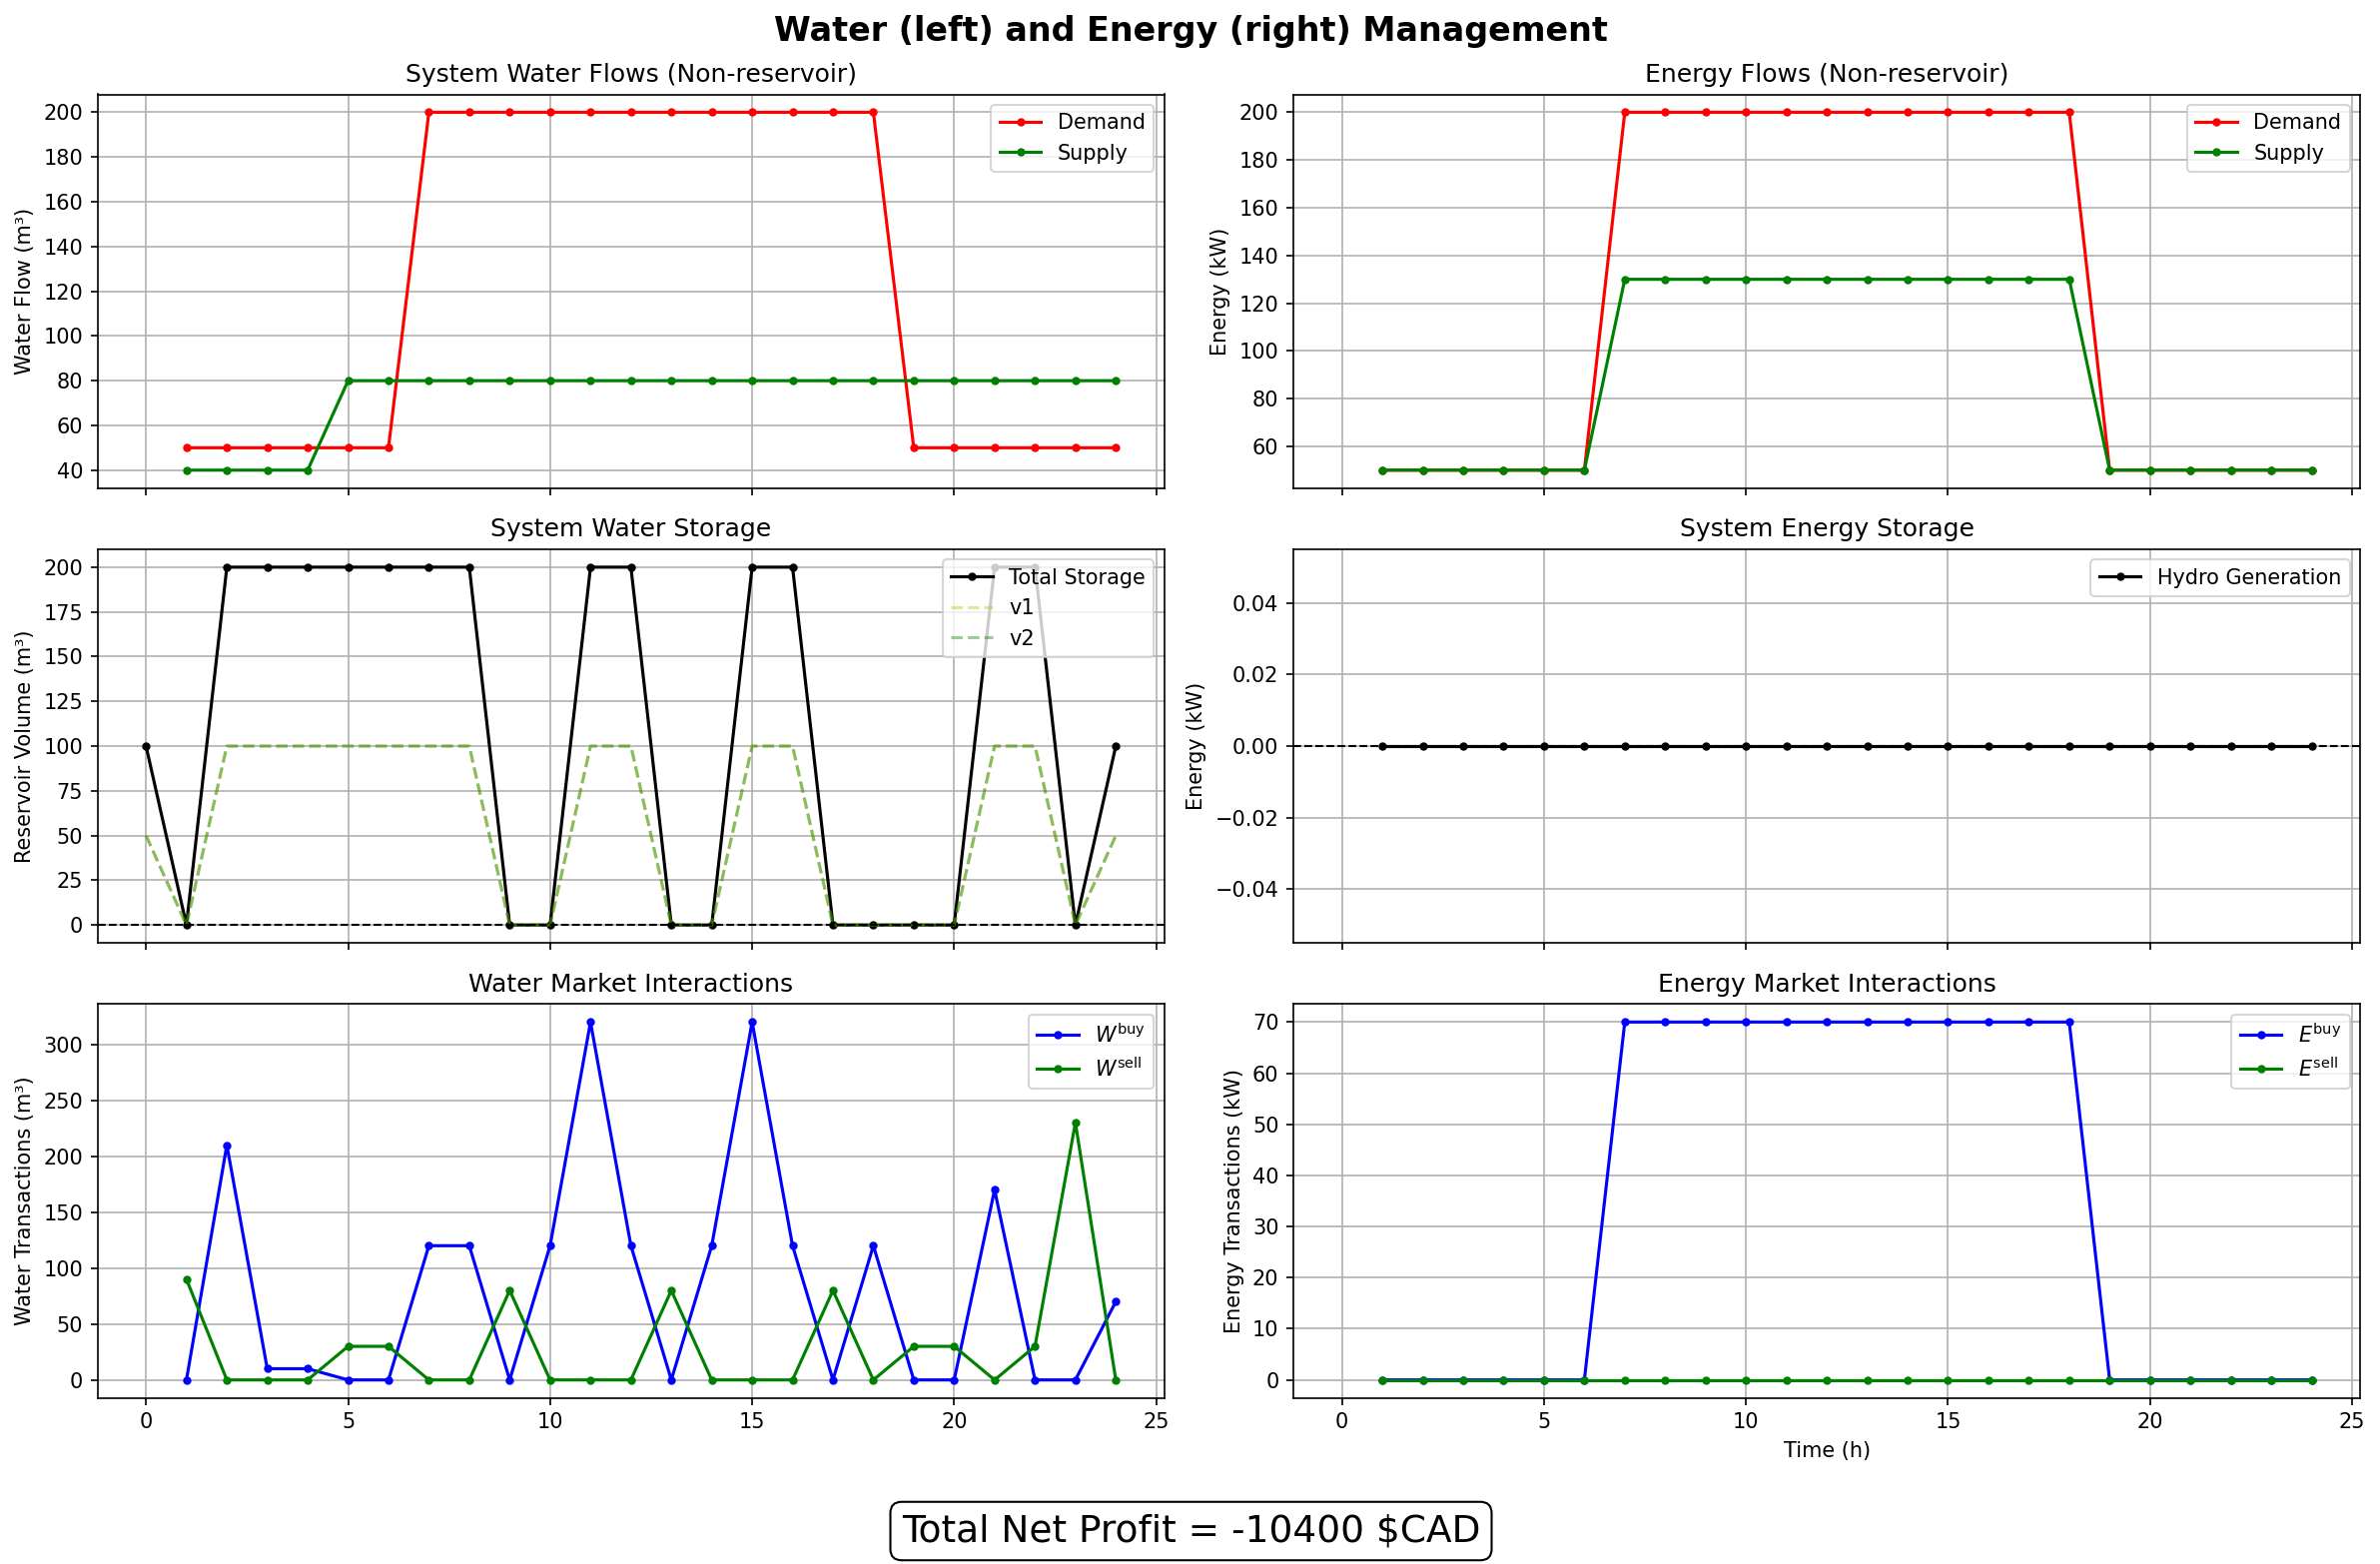

In [52]:
def pumping_dominant_expectations(summary, model):
    eps = 1e-6
    pump_energy = sum(max(0.0, -pyo.value(model.k[i]) * pyo.value(model.q_i[i, t])) for i in model.I for t in model.T)
    return [
        ("Net hydro operation consumes energy", pump_energy > 0.0),
        ("Energy purchases rise to feed pumps", summary['total_e_buy'] > 200.0),
        ("Reservoir volumes stay within limits", all(0.0 <= pyo.value(model.v[j, t]) <= pyo.value(model.v_max[j]) + 1e-6 for j in model.J for t in model.T)),
        ("Terminal storage constraints respected", all(summary['final_volumes'][j] >= pyo.value(model.v_min[j]) - eps for j in model.J))
    ]

pumping_dominant_overrides = {
    'k': {'c_1_2': -1.5, 'c_2_1': -2.0},
    'q_max_i': {'c_1_2': 120, 'c_2_1': 120},
    'rainfall_collection': {t: 40 for t in range(1, 25)}
}

pumping_dominant_model, pumping_dominant_results, pumping_dominant_summary = run_edge_case(
    name='Pumping dominant',
    description='Inter-reservoir transfers act as pumps only.',
    overrides=pumping_dominant_overrides,
    expectation_fn=pumping_dominant_expectations
)

plot_results(pumping_dominant_results, pumping_dominant_model)


#### Infeasible terminal requirement check
Raise the terminal storage requirement beyond physical capacity. The solver should report infeasibility, illustrating how to detect impossible planning targets.


In [53]:
print('Infeasible terminal requirement: forcing v_min above v_max')
infeasible_overrides = {
    'v_min': {'v1': 140, 'v2': 140},
    'v_max': {'v1': 100, 'v2': 100}
}

infeasible_model = build_edge_case_model(infeasible_overrides)
solver = get_available_solver()
try:
    results = solver.solve(infeasible_model, tee=False)
except Exception as exc:
    print(f'Solver failed before reporting feasibility: {exc}')
else:
    condition = results.solver.termination_condition
    print(f'Solver termination: {condition}')
    if condition == pyo.TerminationCondition.optimal:
        print('Unexpectedly feasible – double-check overrides.')
    else:
        print('As expected, the tightened terminal requirement cannot be satisfied.')


Infeasible terminal requirement: forcing v_min above v_max
model.name="unknown";
    - termination condition: infeasibleOrUnbounded
    - message from solver: Problem proven to be infeasible or unbounded.
Solver termination: infeasibleOrUnbounded
As expected, the tightened terminal requirement cannot be satisfied.


#### Edge-case result table
Summarize the aggregated buy/sell volumes and terminal storage levels for each scenario. Run the scenario cells first so their summaries are populated.


In [39]:
import pandas as pd

edge_case_summaries = [
    ('Scarcity', 'scarcity_summary'),
    ('Surplus', 'surplus_summary'),
    ('Tight storage', 'tight_storage_summary'),
    ('Turbine outage', 'turbine_outage_summary'),
    ('Inter-reservoir bottleneck', 'bottleneck_summary'),
    ('Price arbitrage', 'price_arbitrage_summary'),
    ('Demand surge', 'demand_surge_summary'),
    ('Pumping dominant', 'pumping_dominant_summary')
]

rows = []
for label, var_name in edge_case_summaries:
    summary = globals().get(var_name)
    if summary is None:
        rows.append({
            'scenario': label,
            'status': 'Not run',
            'total_w_buy': float('nan'),
            'total_w_sell': float('nan'),
            'total_e_buy': float('nan'),
            'total_e_sell': float('nan'),
            'final_v1': float('nan'),
            'final_v2': float('nan'),
        })
        continue

    rows.append({
        'scenario': label,
        'status': 'Solved',
        'total_w_buy': summary['total_w_buy'],
        'total_w_sell': summary['total_w_sell'],
        'total_e_buy': summary['total_e_buy'],
        'total_e_sell': summary['total_e_sell'],
        'final_v1': summary['final_volumes'].get('v1'),
        'final_v2': summary['final_volumes'].get('v2'),
    })

results_df = pd.DataFrame(rows)
display(results_df)


,scenario,status,total_w_buy,total_w_sell,total_e_buy,total_e_sell,final_v1,final_v2
0,Scarcity,Solved,3000.0,0.0,1200.0,100.0,50.0,50.0
1,Surplus,Solved,0.0,1800.0,0.0,6120.0,50.0,50.0
2,Tight storage,Solved,0.0,1670.0,0.0,3120.0,95.0,95.0
3,Turbine outage,Solved,2040.0,0.0,2040.0,0.0,50.0,50.0
4,Inter-reservoir bottleneck,Solved,1000.0,240.0,1296.0,384.0,50.0,50.0
5,Price arbitrage,Solved,4350.0,5750.0,9200.0,14120.0,50.0,50.0
6,Demand surge,Solved,2520.0,340.0,420.0,220.0,50.0,50.0
7,Pumping dominant,Solved,1320.0,80.0,840.0,0.0,50.0,50.0
